# Импортирование необходимых библиотек

In [164]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime
import os
import csv
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)

# catalog.get_info()

# Получение координат экспериментального пастбища 

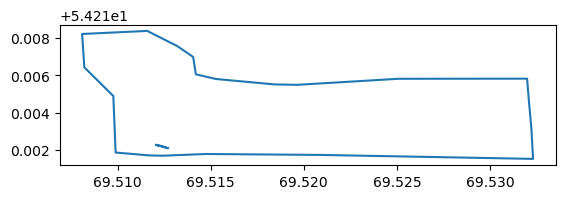

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Доступные базы данных (Спутиковые базы!!!)

In [8]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


# Выбор одной из доступных баз данных

In [9]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])

# Составление запросов

In [10]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

In [11]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DN"
            }}],
            output: {{
                bands: 13,
                sampleType: "INT16"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in bands_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2}
evalscript_all_bands = evalscript_all_bands.format(**settings)

# Снимки на даты (с 01.05.2022 по 31.08.2022)

In [12]:
time_interval = "2022-05-01", "2022-08-31"

search_iterator = catalog.search(
    data_collection,
    bbox=pasture_bbox,
    time=time_interval,
    filter="eo:cloud_cover <= 100",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

# results

Total number of results: 49


In [13]:
time_difference = datetime.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

# unique_acquisitions

In [14]:
true_color_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    true_color_process_requests.append(request)

In [15]:
all_bands_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    all_bands_process_requests.append(request)

In [16]:
%%time

client = SentinelHubDownloadClient(config=config)
true_color_download_requests = [request.download_list[0] for request in true_color_process_requests]
true_color_data = client.download(true_color_download_requests)

Wall time: 5.17 s


In [17]:
%%time

client = SentinelHubDownloadClient(config=config)
all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
all_bands_data = client.download(all_bands_download_requests)

Wall time: 6.12 s


# Составление маски пастбища

In [18]:
 aoi_height, aoi_width, _ = true_color_data[-1].shape

In [19]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = masks[0]&masks[1]&masks[2]&masks[3]&masks[4]&masks[5]&masks[6]

# Маска для загона №1 

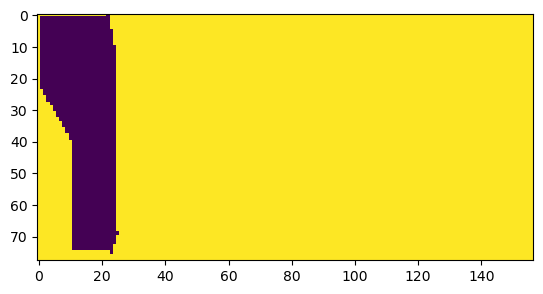

In [20]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

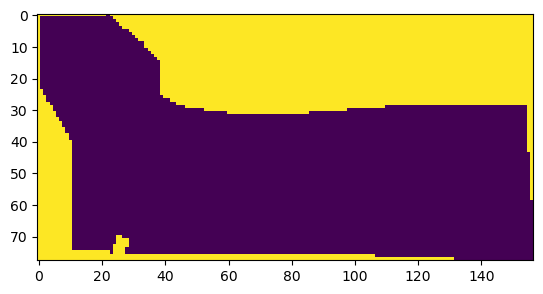

In [21]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Выбор порога облачности

In [22]:
white_noise_threshold = 255 # Значение [0-255]  
white_noise_count = 10000 # Количество 157*78=[0-12246]

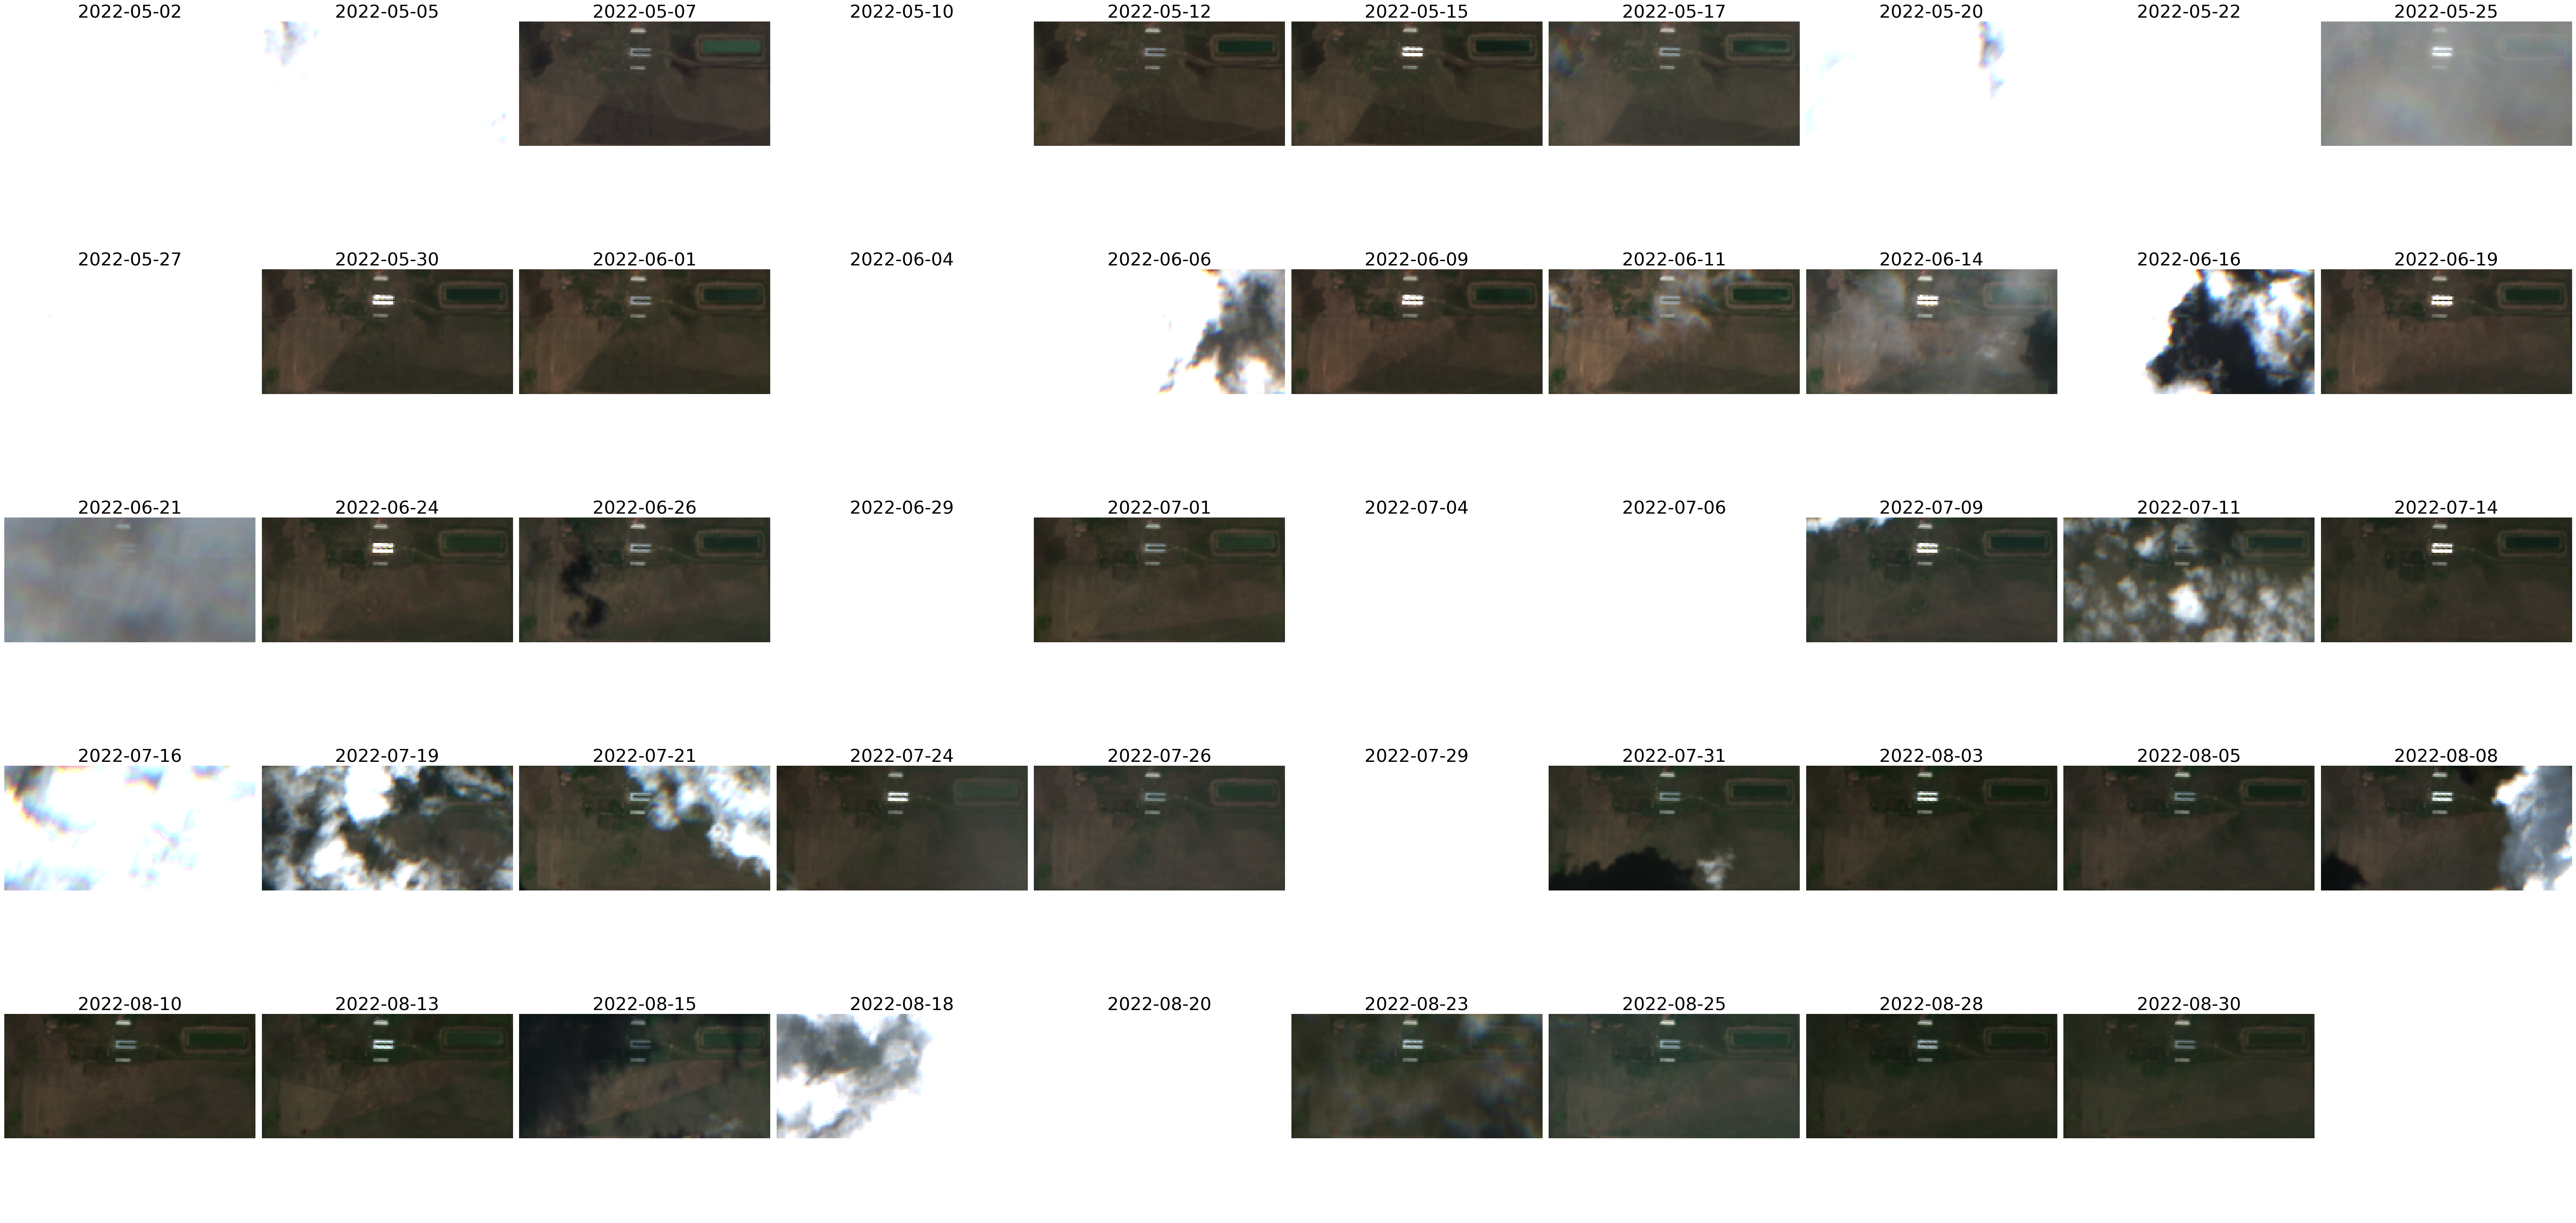

In [23]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(true_color_data, unique_acquisitions)):
    mx1 = ma.masked_array(image[:,:,0], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx2 = ma.masked_array(image[:,:,1], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx3 = ma.masked_array(image[:,:,2], mask=combined_mask.reshape(aoi_height, aoi_width))
    comb = mx1&mx2&mx3
    white_image = comb >= white_noise_threshold
    if white_image.sum() <= white_noise_count:
        clear_date_dict.append((str(timestamp.date().isoformat()), i))
        ax = axis[idx // ncols][idx % ncols]
        ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
        ax.set_title(timestamp.date().isoformat(), fontsize=30)
        idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Доступные даты изображении после фильтрации

In [24]:
for date in clear_date_dict:
    print(date)

2022-05-02
2022-05-05
2022-05-07
2022-05-10
2022-05-12
2022-05-15
2022-05-17
2022-05-20
2022-05-22
2022-05-25
2022-05-27
2022-05-30
2022-06-01
2022-06-04
2022-06-06
2022-06-09
2022-06-11
2022-06-14
2022-06-16
2022-06-19
2022-06-21
2022-06-24
2022-06-26
2022-06-29
2022-07-01
2022-07-04
2022-07-06
2022-07-09
2022-07-11
2022-07-14
2022-07-16
2022-07-19
2022-07-21
2022-07-24
2022-07-26
2022-07-29
2022-07-31
2022-08-03
2022-08-05
2022-08-08
2022-08-10
2022-08-13
2022-08-15
2022-08-18
2022-08-20
2022-08-23
2022-08-25
2022-08-28
2022-08-30


# Выбор доступной даты 

In [25]:
image_date = clear_date_dict["2022-06-09"]

# Определение основных каналов

In [125]:
BLUE = all_bands_data[image_date][:, :, bands_dict["B02"]]
GREEN = all_bands_data[image_date][:, :, bands_dict["B03"]]
RED = all_bands_data[image_date][:, :, bands_dict["B04"]]

RED_EDGE1 = all_bands_data[image_date][:, :, bands_dict["B05"]]
RED_EDGE2 = all_bands_data[image_date][:, :, bands_dict["B06"]]
RED_EDGE3 = all_bands_data[image_date][:, :, bands_dict["B07"]]

NIR = all_bands_data[image_date][:, :, bands_dict["B08"]]
N_NIR = all_bands_data[image_date][:, :, bands_dict["B8A"]]
WV = all_bands_data[image_date][:, :, bands_dict["B09"]]
if "B10" in bands_dict:
    SWIR_C = all_bands_data[image_date][:, :, bands_dict["B10"]]
SWIR2 = all_bands_data[image_date][:, :, bands_dict["B11"]]
SWIR3 = all_bands_data[image_date][:, :, bands_dict["B12"]]

# Normalized Difference Vegetation Index (NDVI)

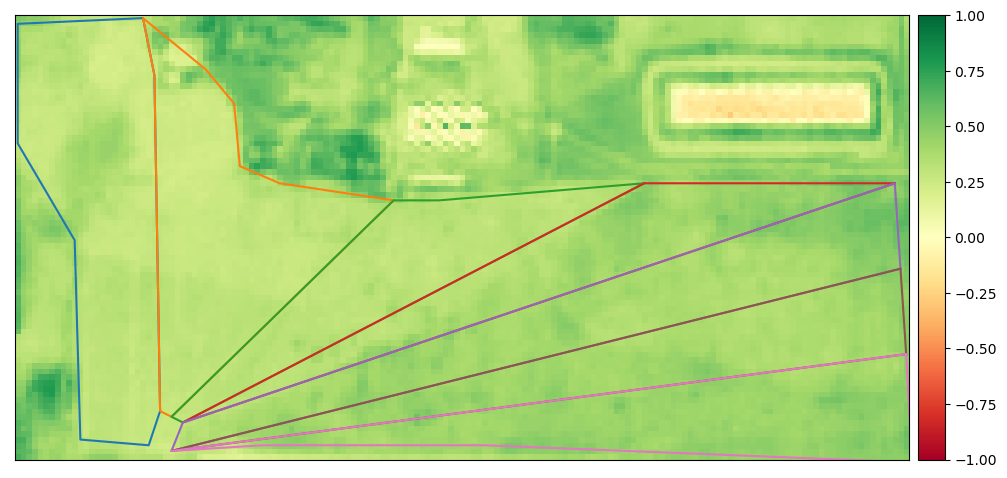

In [81]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):
    
    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ndvi = es.normalized_diff(NIR, RED)

ep.plot_bands(ndvi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

In [27]:
ndvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndvi, mask=mask.reshape(aoi_height, aoi_width))
    ndvi_masked_array.append(mx)

# Статистический анализ данных

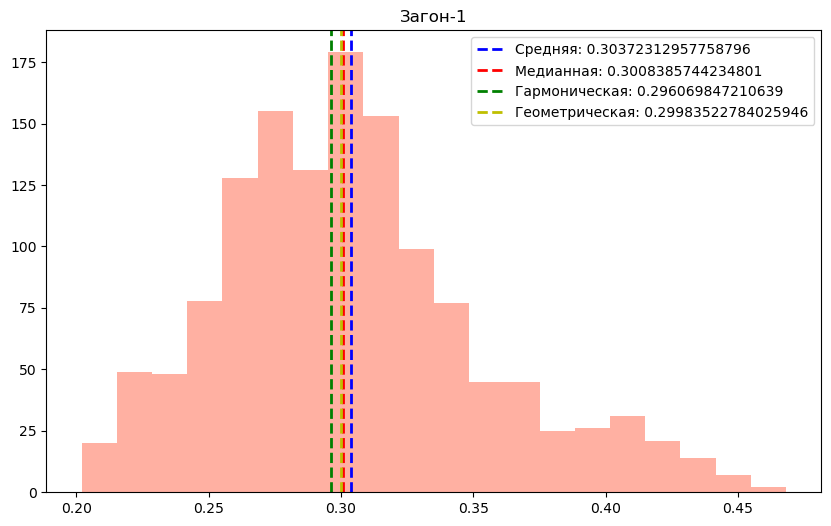

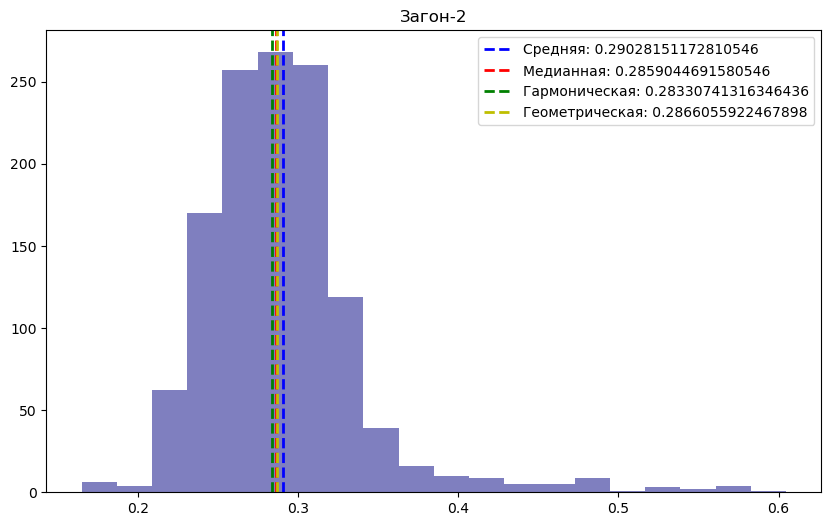

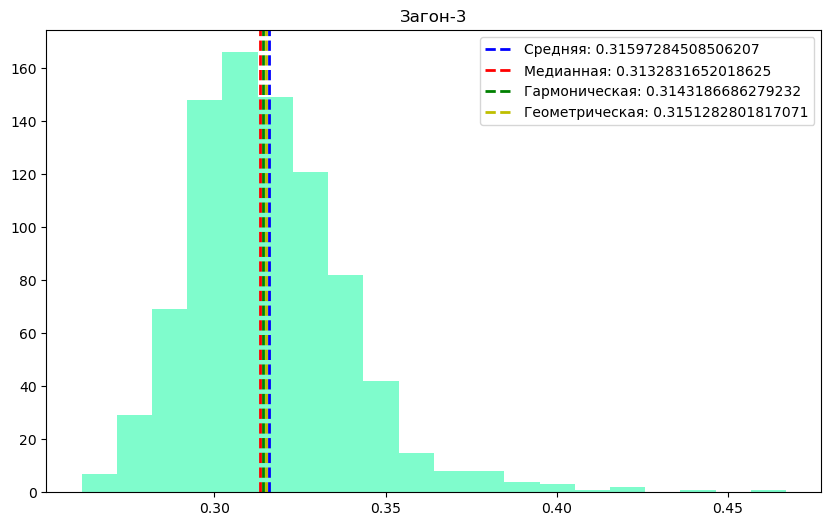

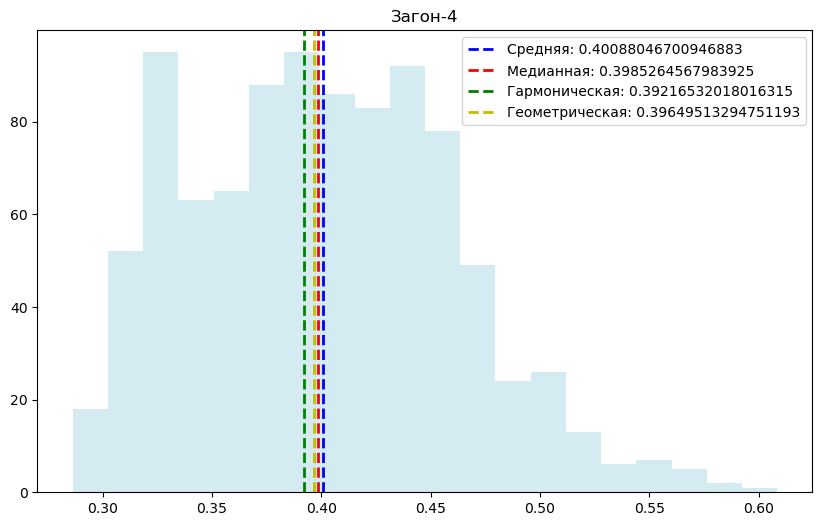

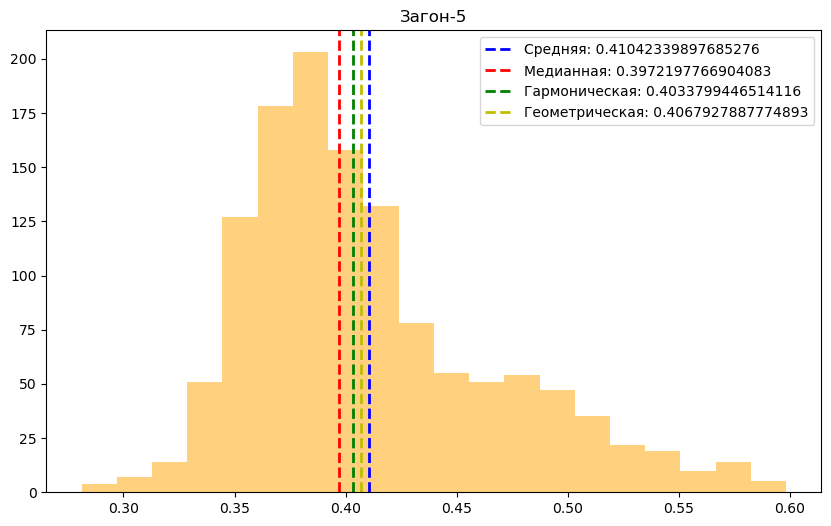

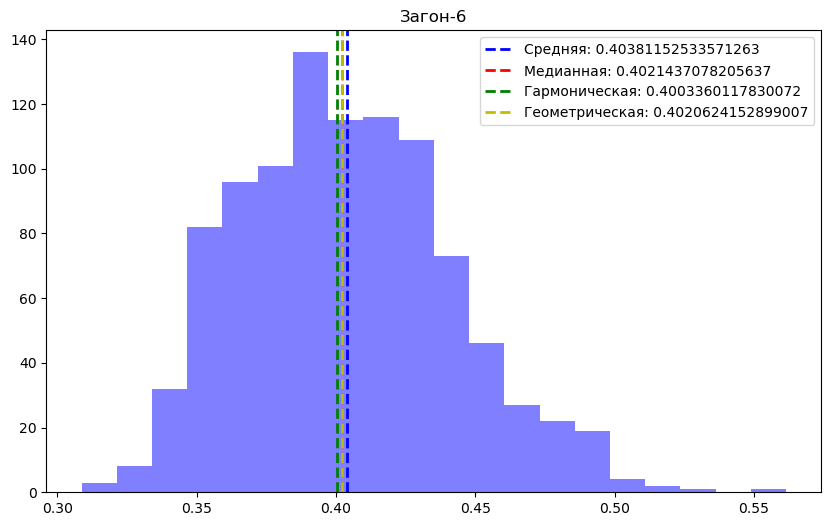

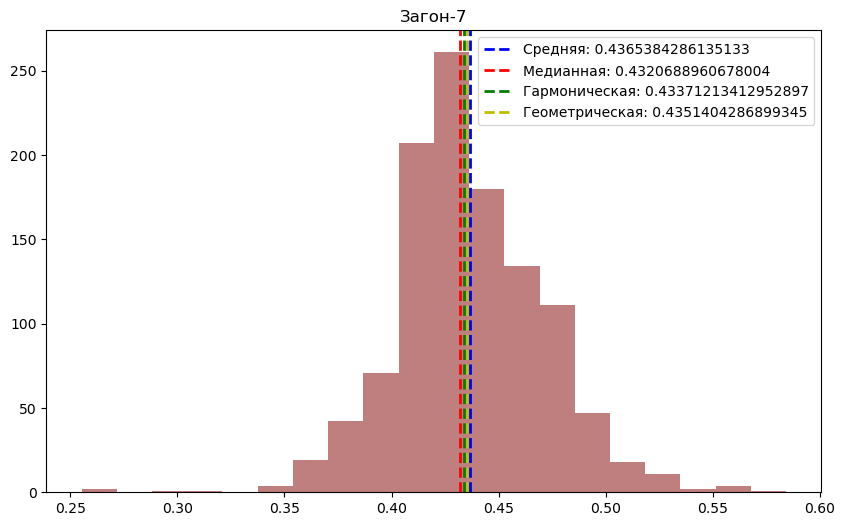

In [28]:
for i, zagon in enumerate(ndvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(ma.mean(ndvi_masked_array[i]), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(ndvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = ndvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {ndvi_masked_array[i].mean()}",f"Медианная: {ma.median(ndvi_masked_array[i])}",f"Гармоническая: {hmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(ndvi_masked_array[i])}",f"Медианная: {ma.median(ndvi_masked_array[i])}"])
plt.show()

# Soil Adjusted Vegetation Index (SAVI)

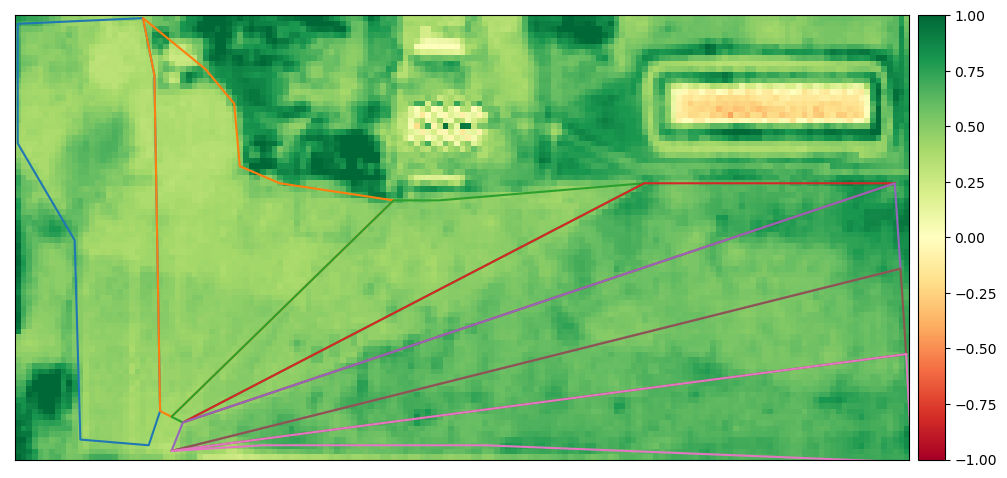

In [82]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

L = 0.5
savi = (NIR - RED) / (NIR + RED + L) * (1 + L)

ep.plot_bands(savi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [83]:
savi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(savi, mask=mask.reshape(aoi_height, aoi_width))
    savi_masked_array.append(mx)

# Статистический анализ данных

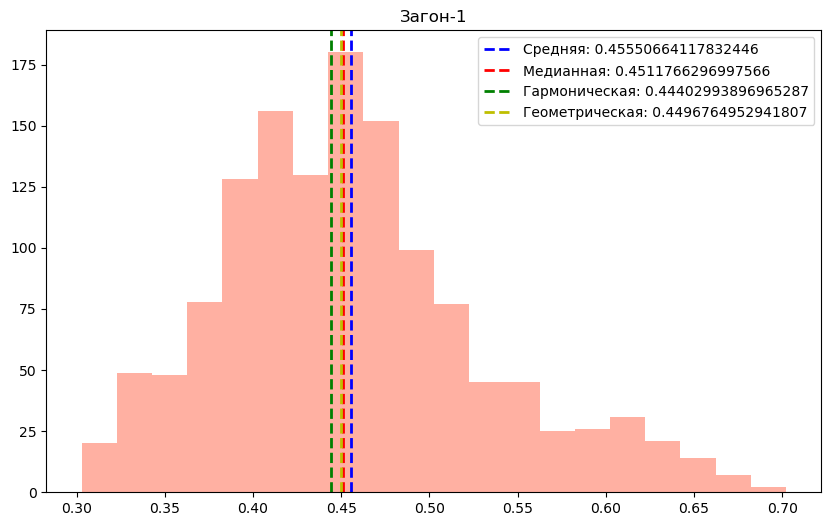

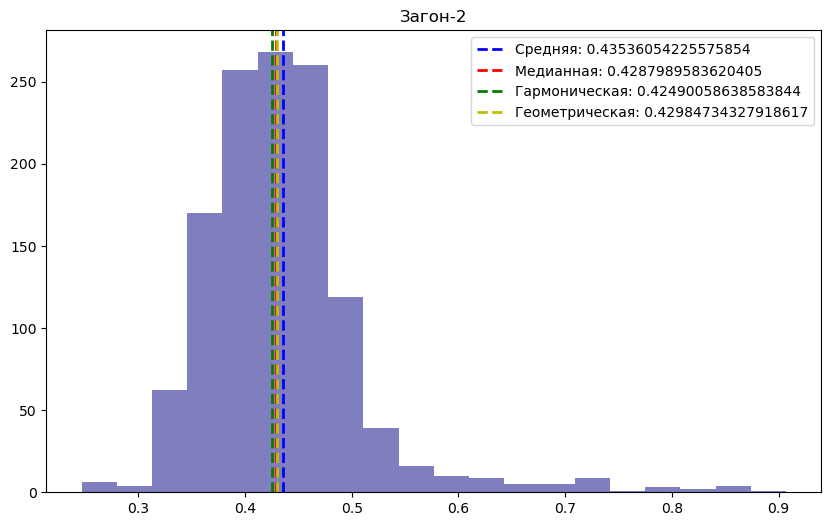

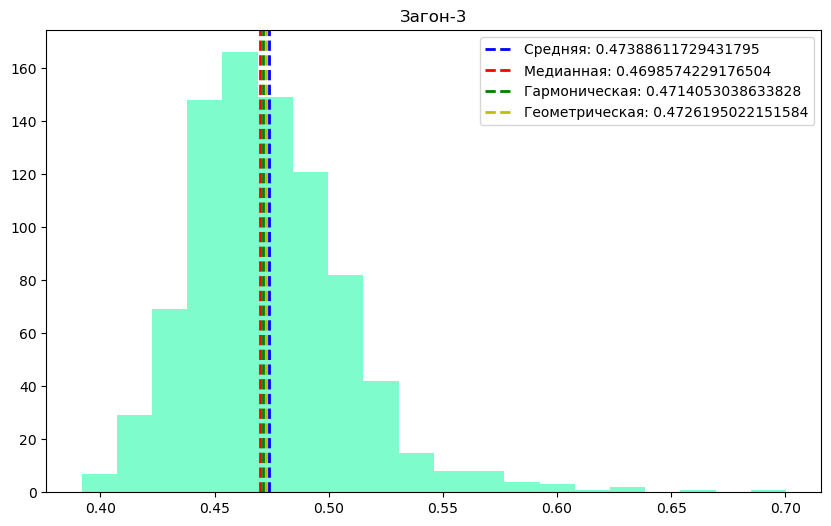

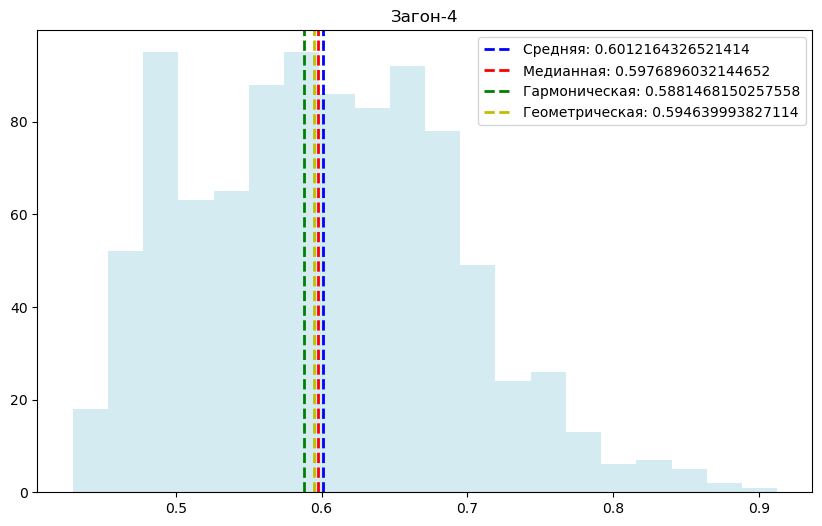

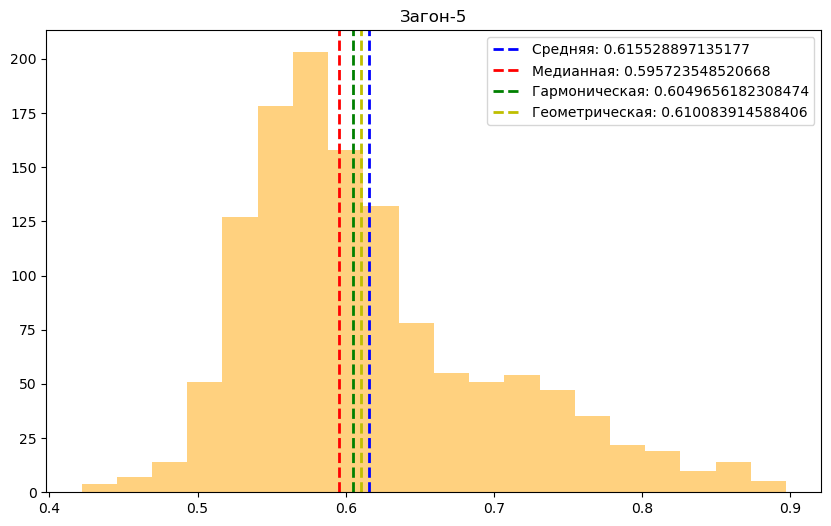

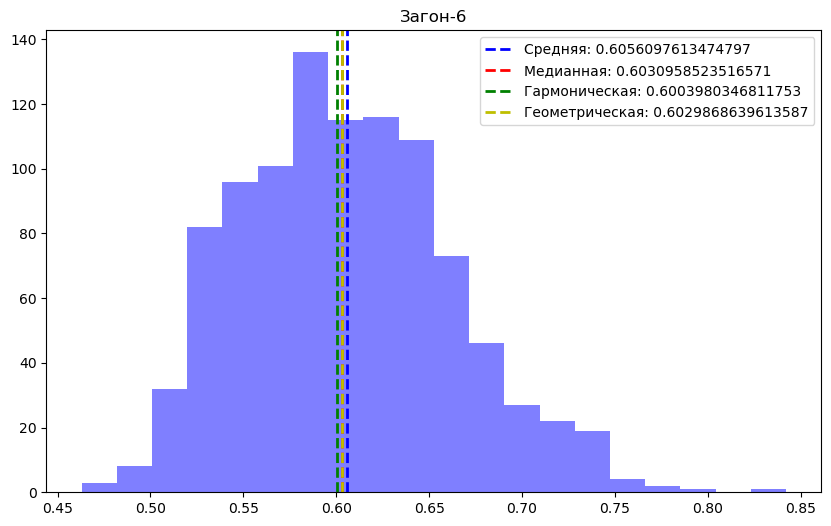

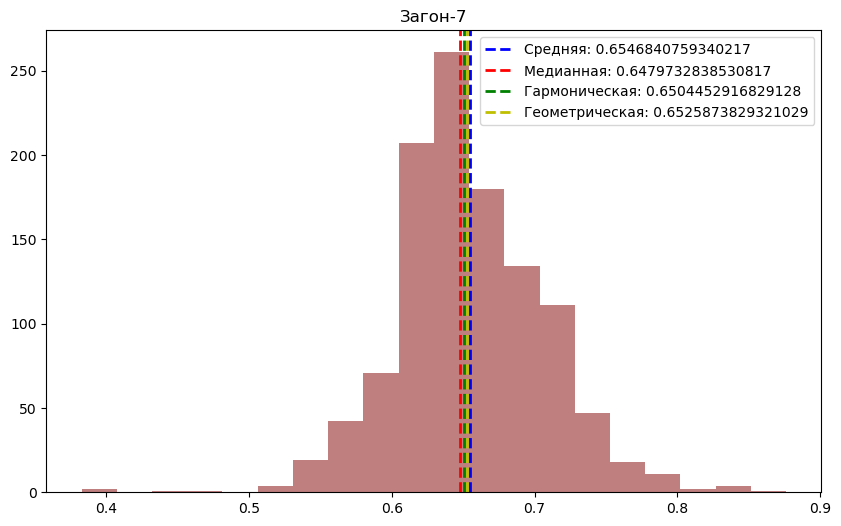

In [84]:
for i, zagon in enumerate(savi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(savi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(savi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = savi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(savi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(savi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {savi_masked_array[i].mean()}",f"Медианная: {ma.median(savi_masked_array[i])}",f"Гармоническая: {hmean(savi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(savi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(savi_masked_array[i])}",f"Медианная: {ma.median(savi_masked_array[i])}"])
plt.show()

# Red Edge Vegetation Index (REVI)

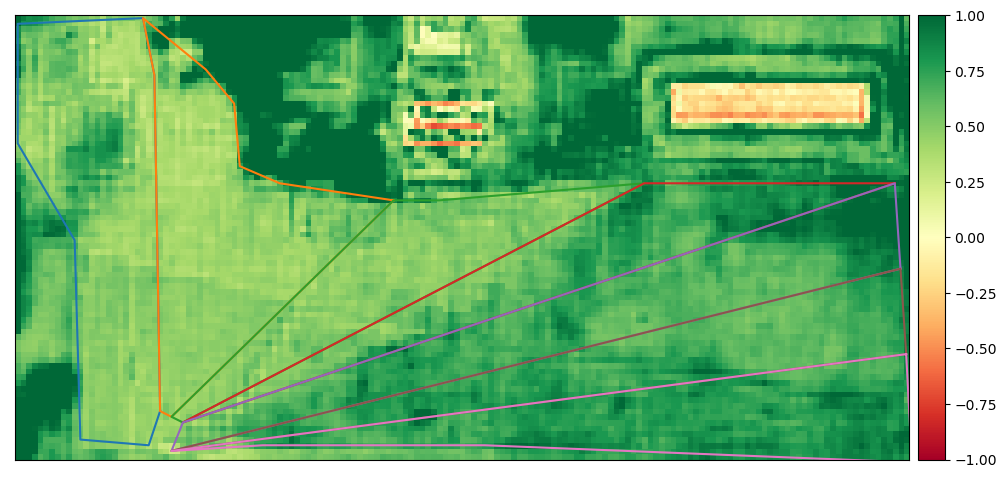

In [85]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

revi = (NIR / RED_EDGE1) - 1

ep.plot_bands(revi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [86]:
revi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(revi, mask=mask.reshape(aoi_height, aoi_width))
    revi_masked_array.append(mx)

# Статистический анализ данных

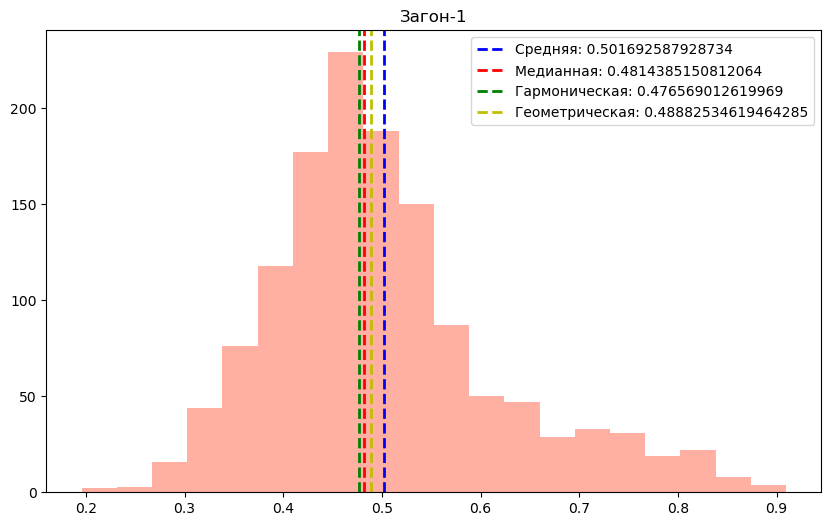

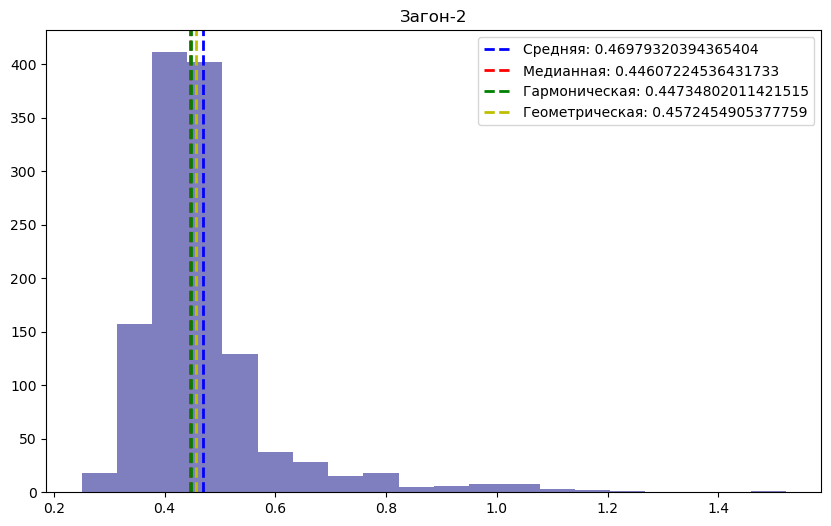

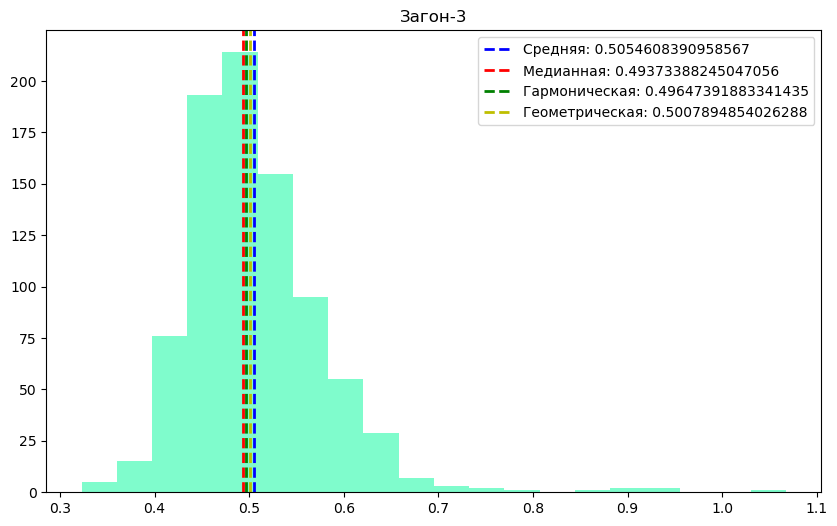

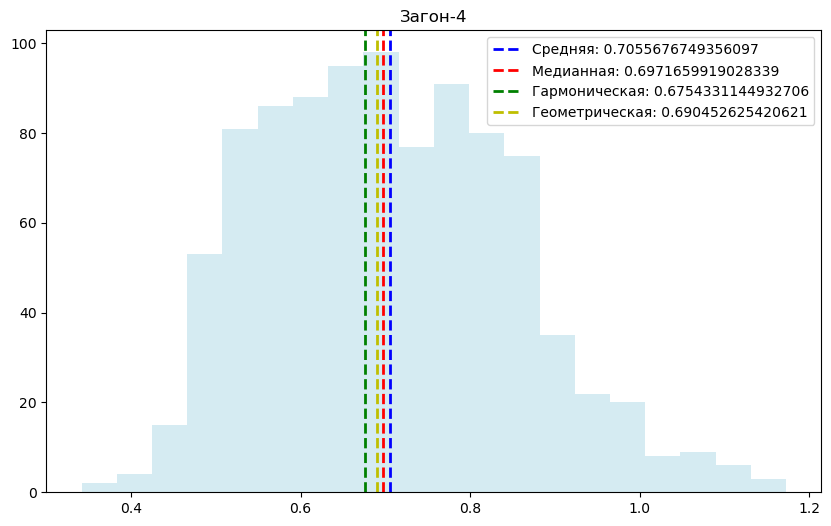

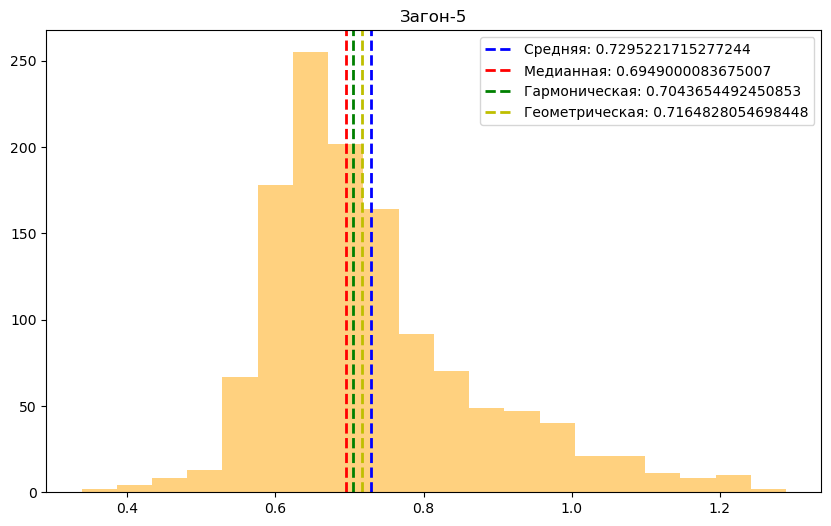

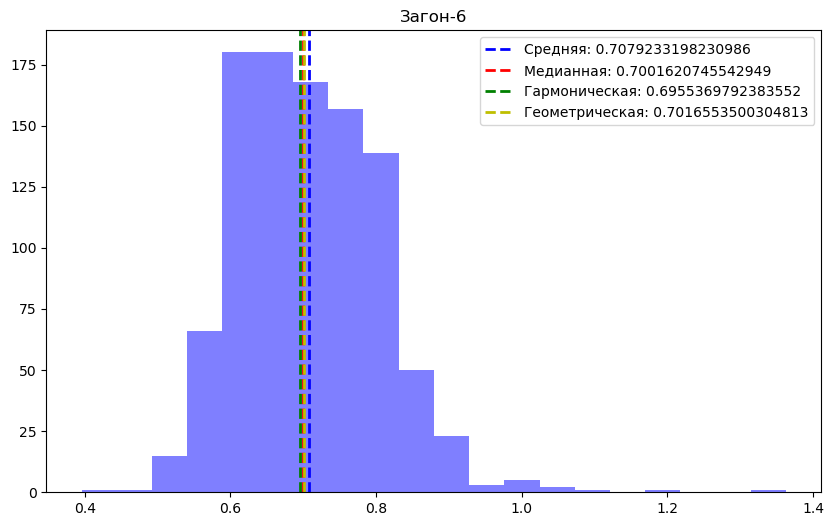

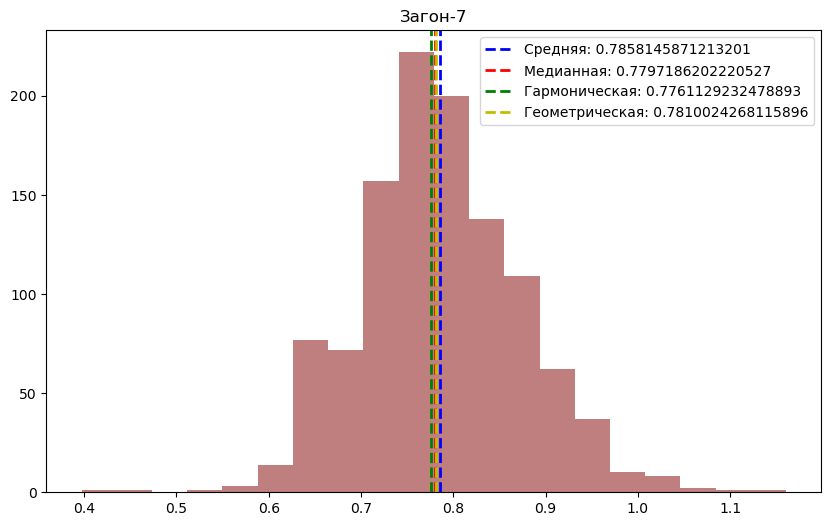

In [87]:
for i, zagon in enumerate(revi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(revi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(revi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = revi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(revi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(revi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {revi_masked_array[i].mean()}",f"Медианная: {ma.median(revi_masked_array[i])}",f"Гармоническая: {hmean(revi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(revi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(revi_masked_array[i])}",f"Медианная: {ma.median(revi_masked_array[i])}"])
plt.show()

# Enhanced Vegetation Index (EVI)

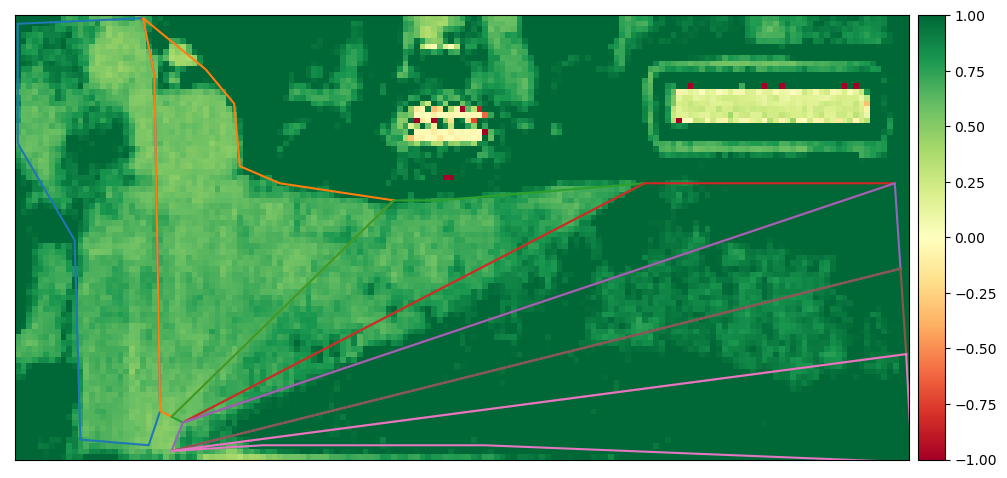

In [88]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

evi = 2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)

ep.plot_bands(evi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [89]:
evi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(evi, mask=mask.reshape(aoi_height, aoi_width))
    evi_masked_array.append(mx)

# Статистический анализ данных

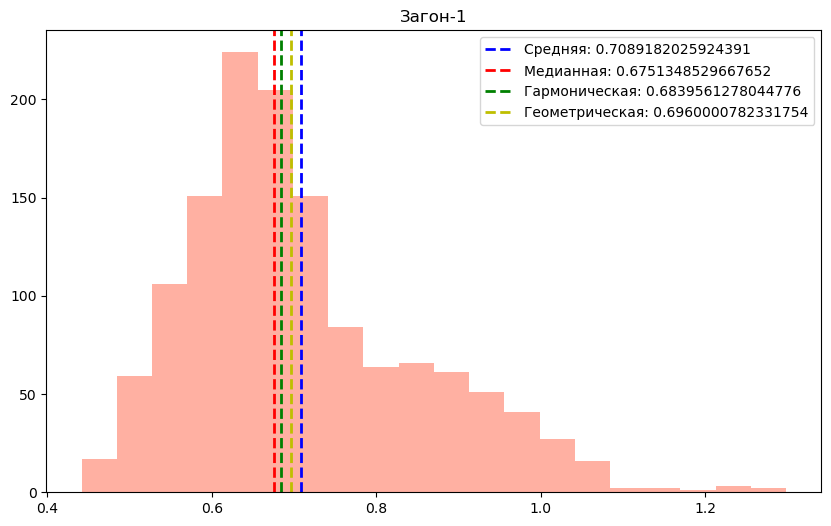

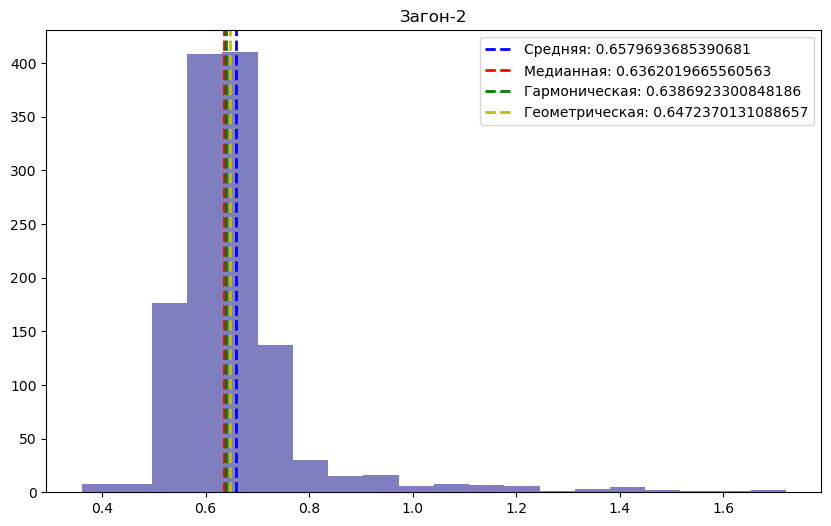

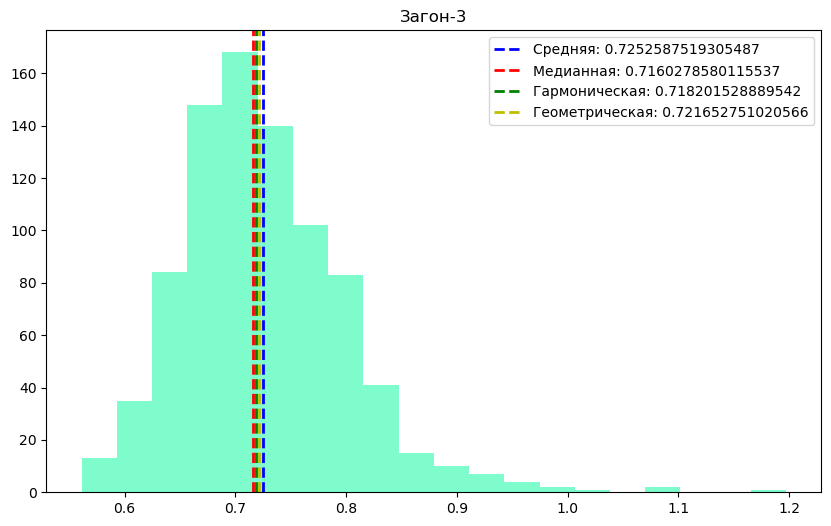

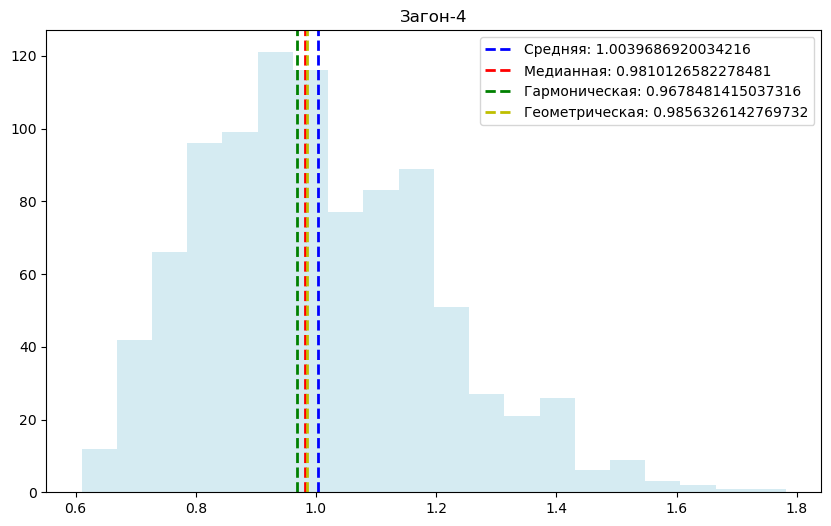

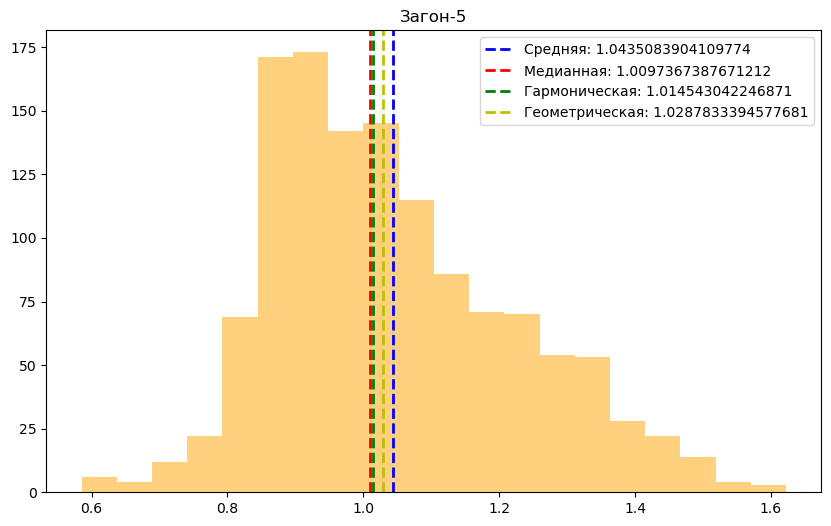

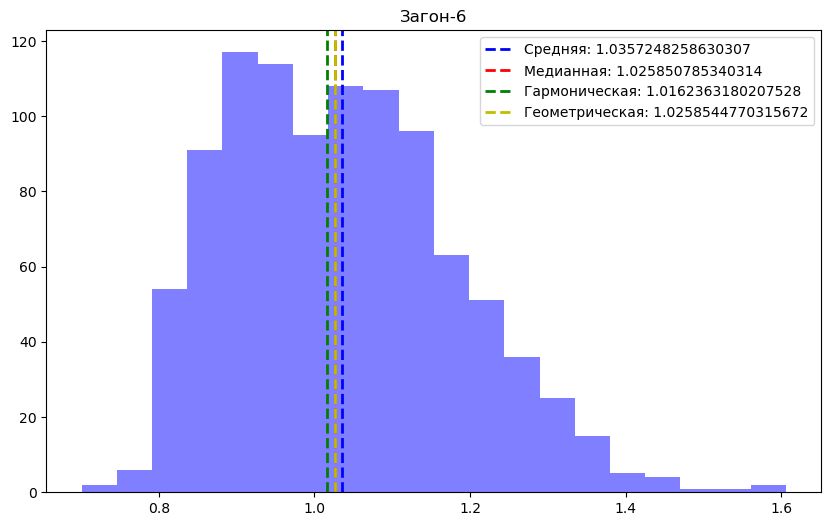

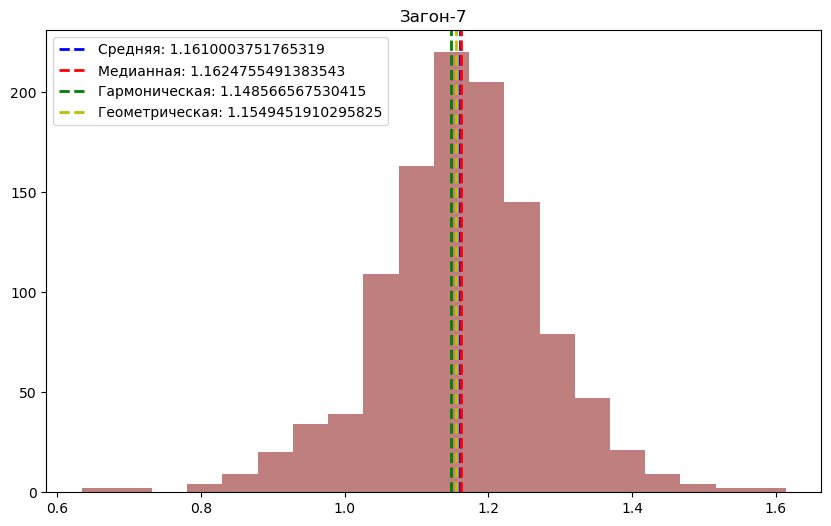

In [90]:
for i, zagon in enumerate(evi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(evi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(evi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = evi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(evi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(evi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {evi_masked_array[i].mean()}",f"Медианная: {ma.median(evi_masked_array[i])}",f"Гармоническая: {hmean(evi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(evi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(evi_masked_array[i])}",f"Медианная: {ma.median(evi_masked_array[i])}"])
plt.show()

# Transformed Vegetation Index (TVI)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_9876\3749082929.py:6: RuntimeWarning: invalid value encountered in sqrt
  tvi = np.sqrt((NIR - RED) / (NIR + RED) + 0.0)


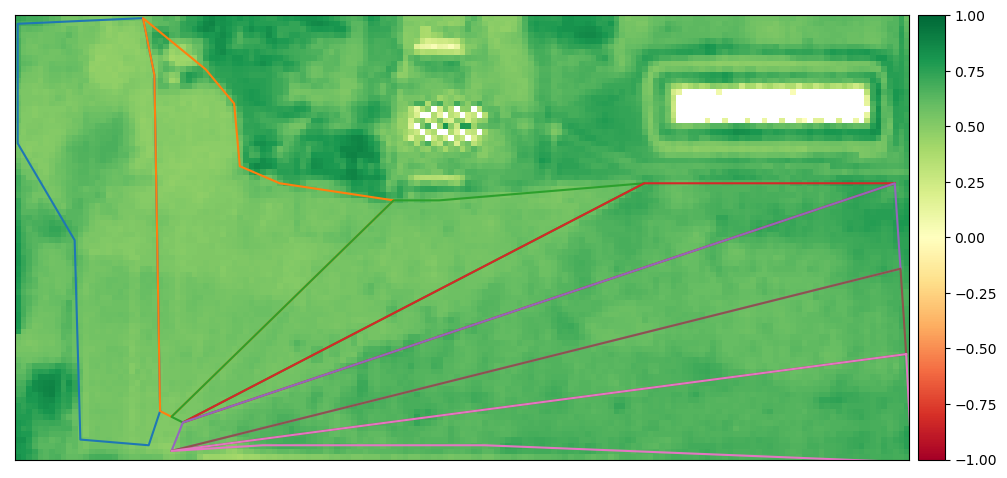

In [91]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

tvi = np.sqrt((NIR - RED) / (NIR + RED) + 0.0)

ep.plot_bands(tvi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [92]:
tvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(tvi, mask=mask.reshape(aoi_height, aoi_width))
    tvi_masked_array.append(mx)

# Статистический анализ данных

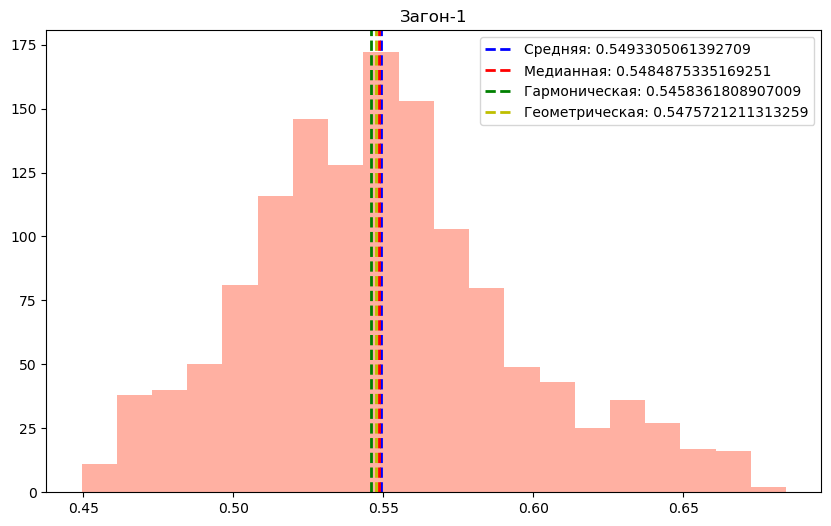

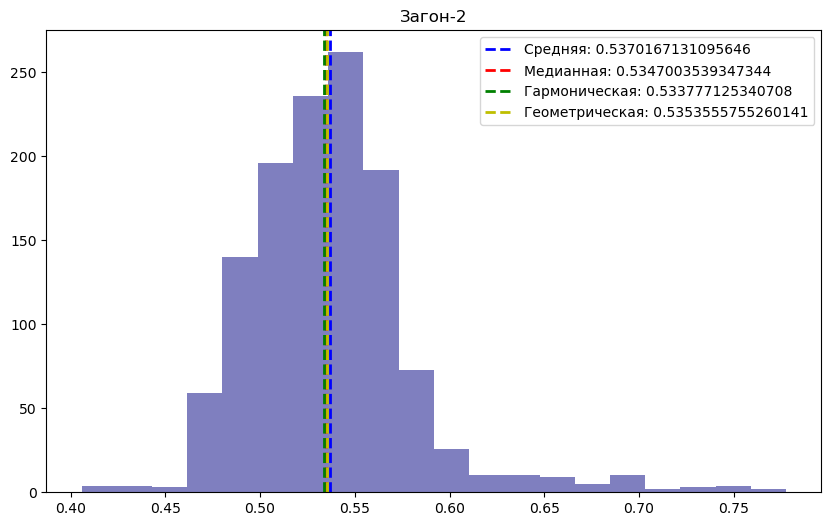

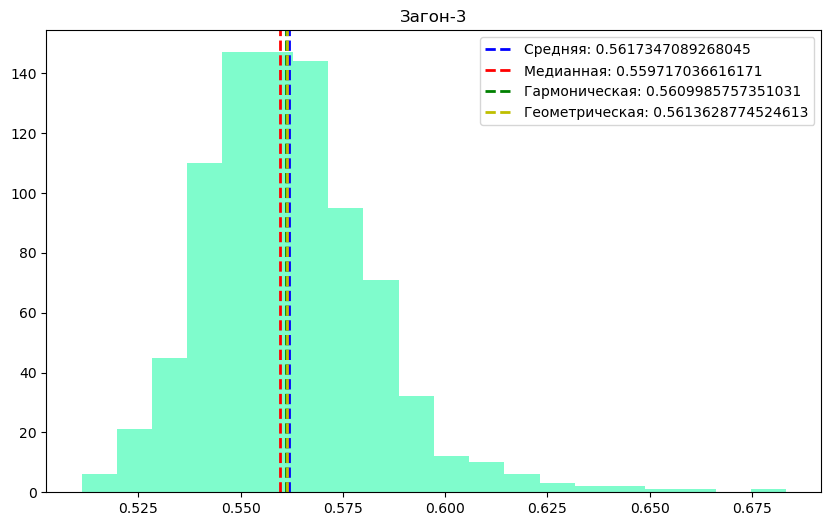

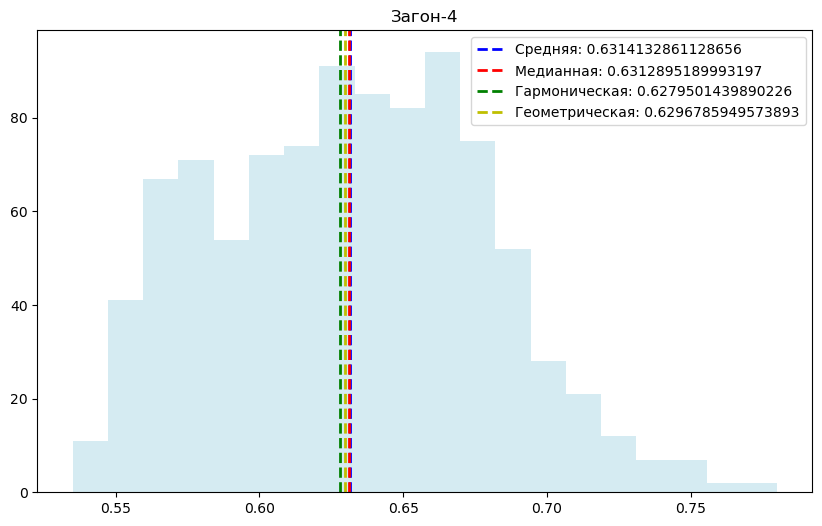

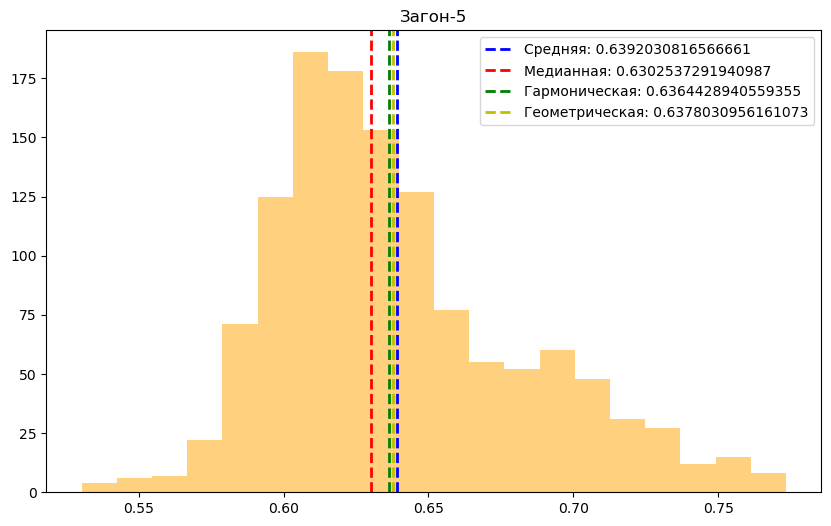

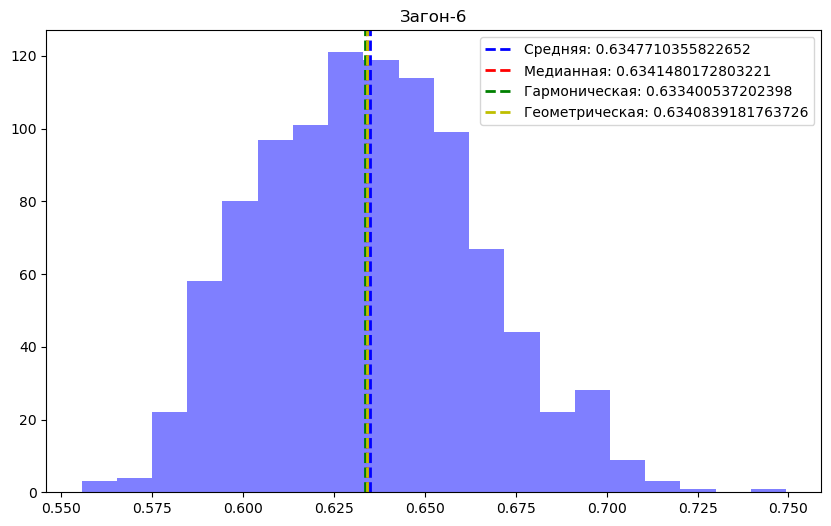

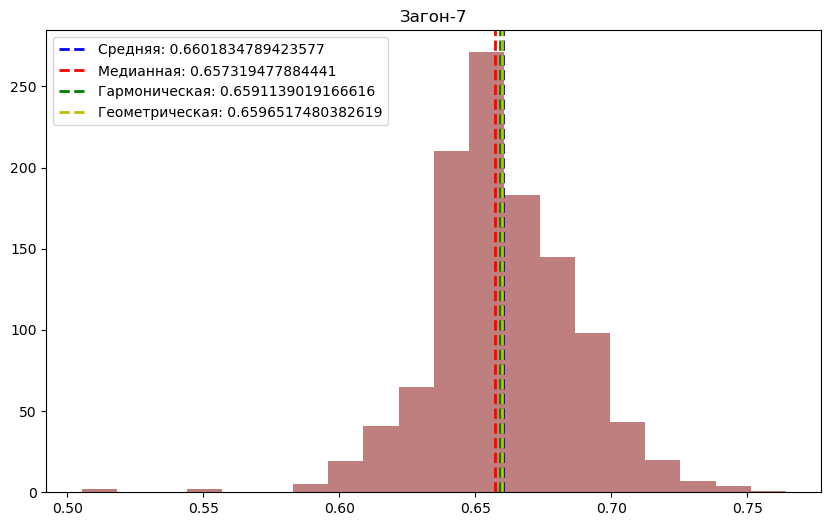

In [93]:
for i, zagon in enumerate(tvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(tvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(tvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = tvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(tvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(tvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {tvi_masked_array[i].mean()}",f"Медианная: {ma.median(tvi_masked_array[i])}",f"Гармоническая: {hmean(tvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(tvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(tvi_masked_array[i])}",f"Медианная: {ma.median(tvi_masked_array[i])}"])
plt.show()

# Green Normalized Difference Vegetation Index (GNDVI)

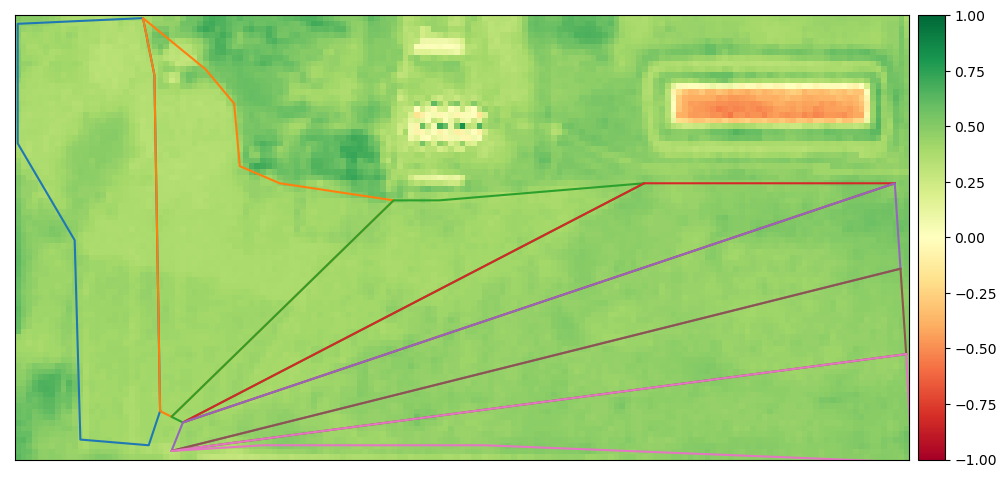

In [94]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

gndvi = (NIR - GREEN) / (NIR + GREEN)    

ep.plot_bands(gndvi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [95]:
gndvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(gndvi, mask=mask.reshape(aoi_height, aoi_width))
    gndvi_masked_array.append(mx)

# Статистический анализ данных

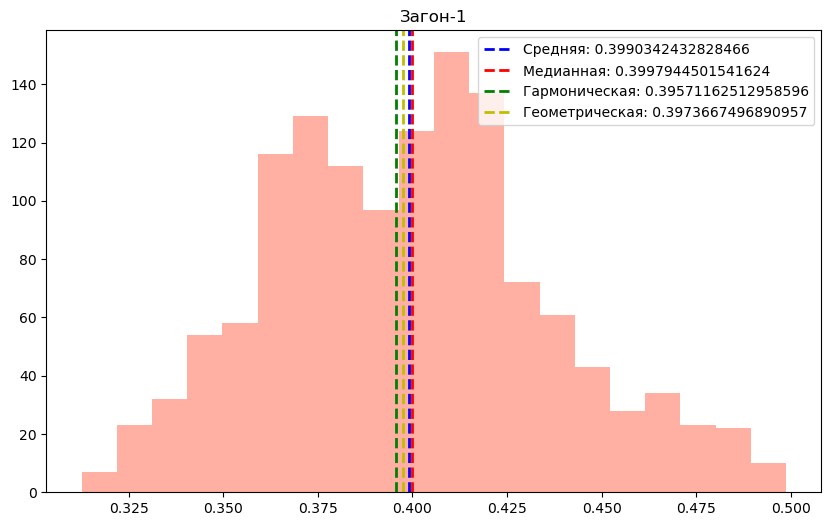

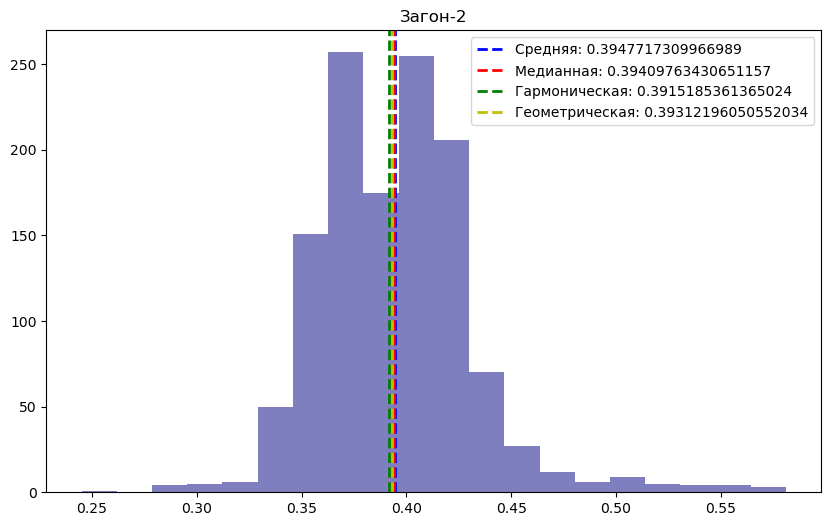

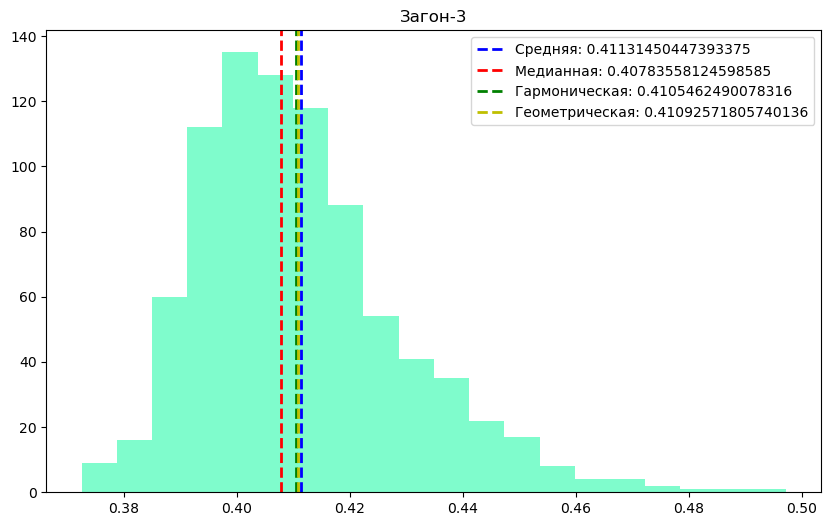

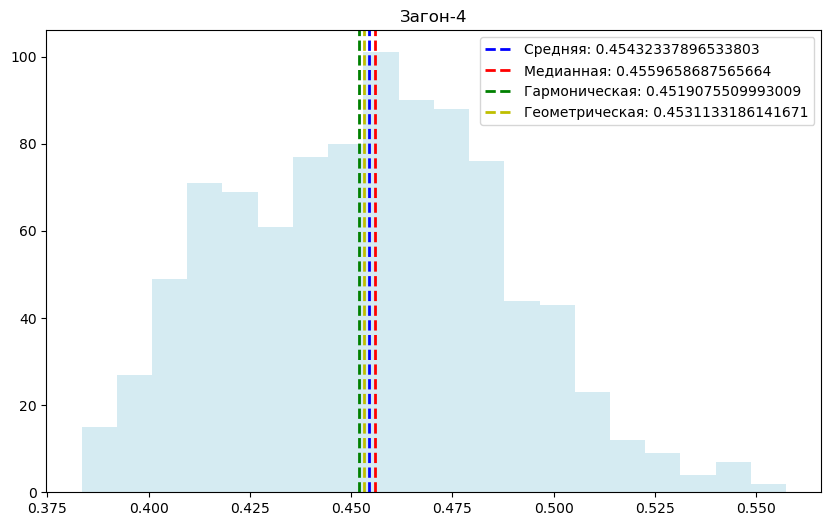

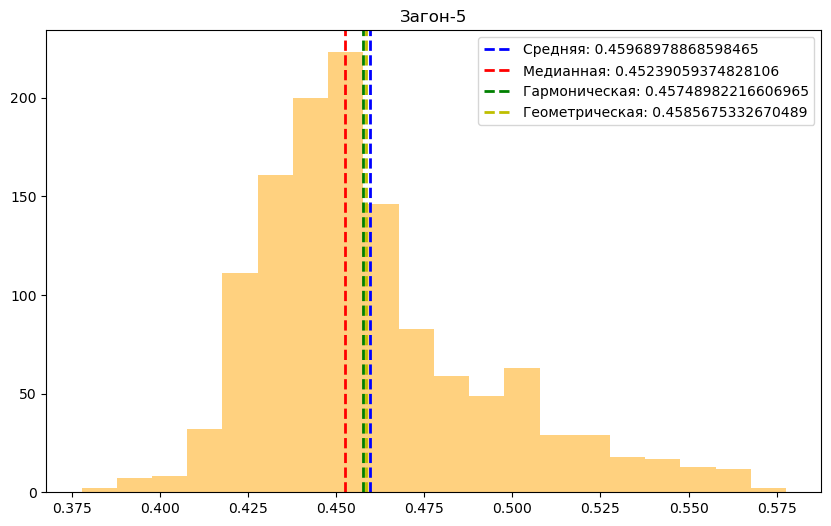

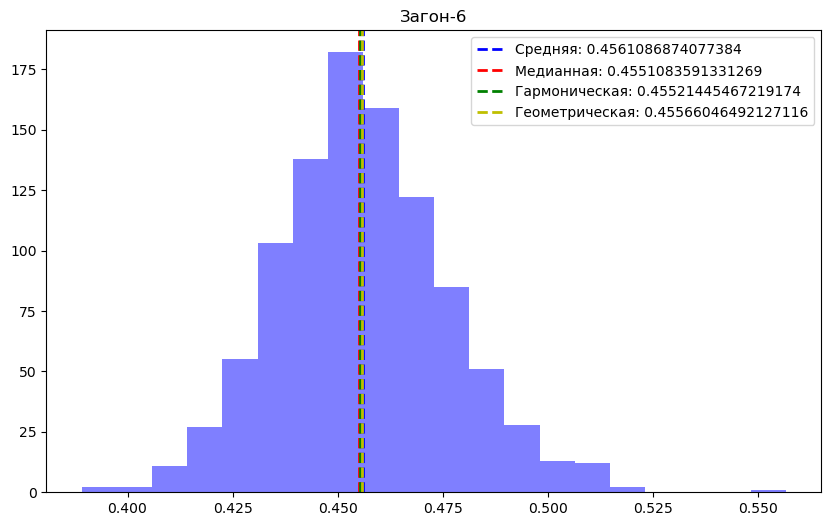

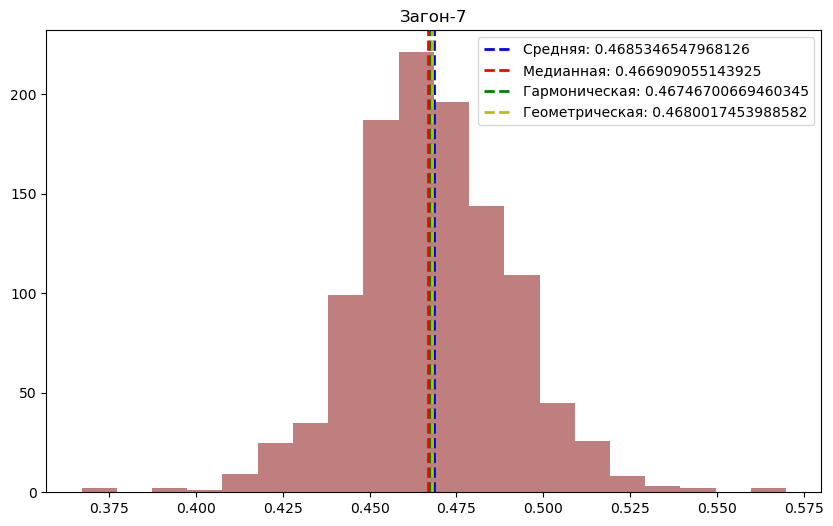

In [96]:
for i, zagon in enumerate(gndvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(gndvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(gndvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = gndvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(gndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(gndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {gndvi_masked_array[i].mean()}",f"Медианная: {ma.median(gndvi_masked_array[i])}",f"Гармоническая: {hmean(gndvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(gndvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(gndvi_masked_array[i])}",f"Медианная: {ma.median(gndvi_masked_array[i])}"])
plt.show()

# Normalized Difference Infrared Index (NDII)

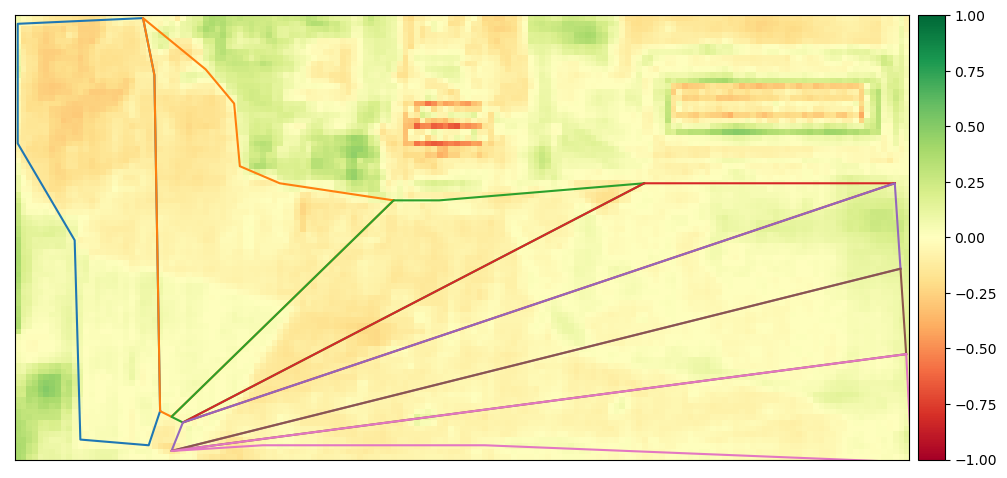

In [116]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ndii = (NIR - SWIR3) / (NIR + SWIR3)

ep.plot_bands(ndii, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [117]:
ndii_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndii, mask=mask.reshape(aoi_height, aoi_width))
    ndii_masked_array.append(mx)

# Статистический анализ данных

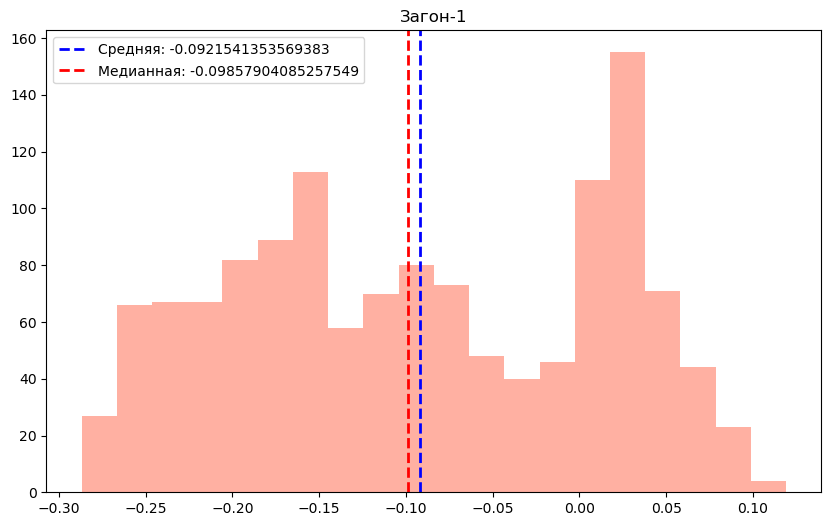

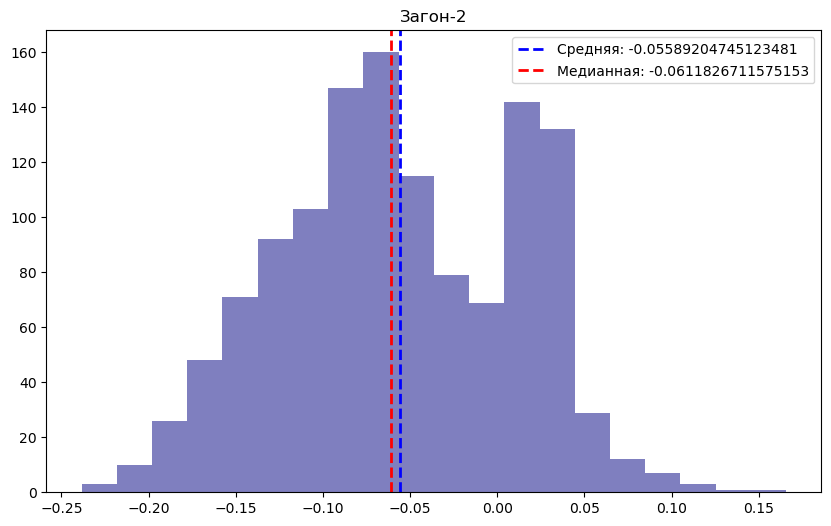

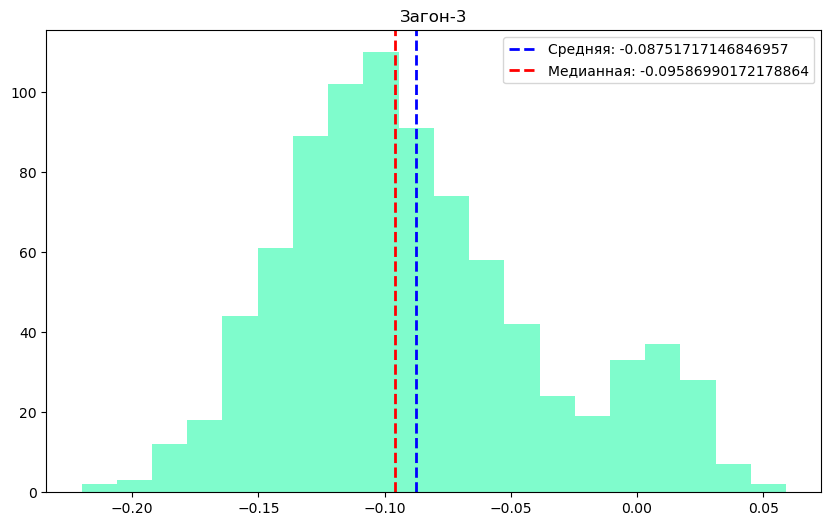

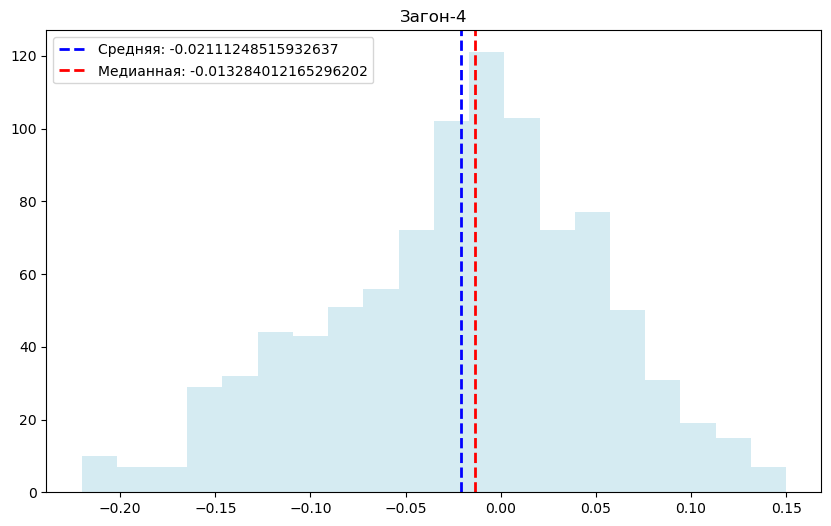

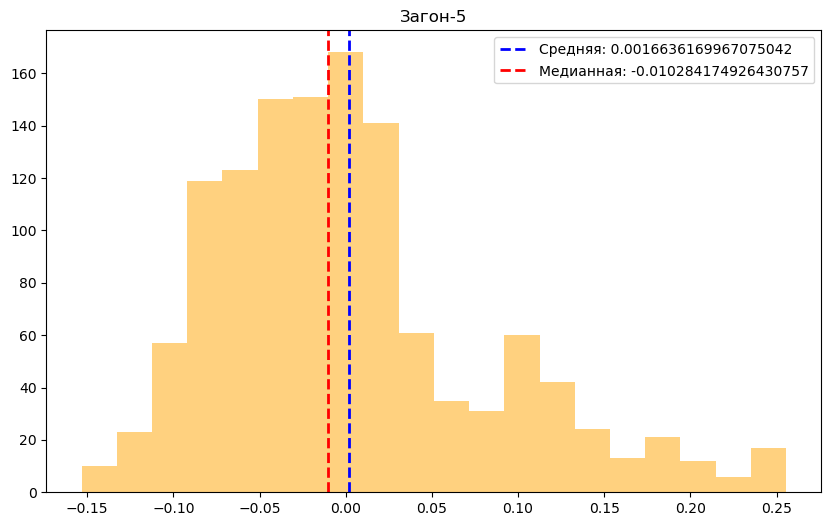

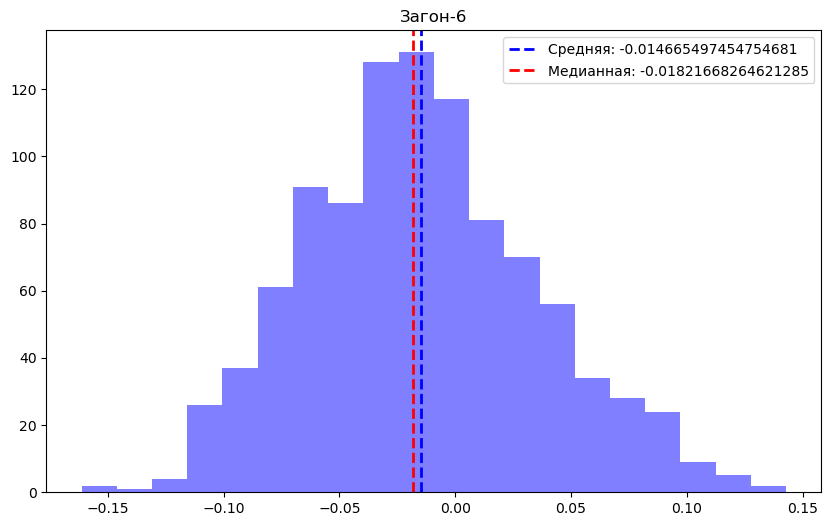

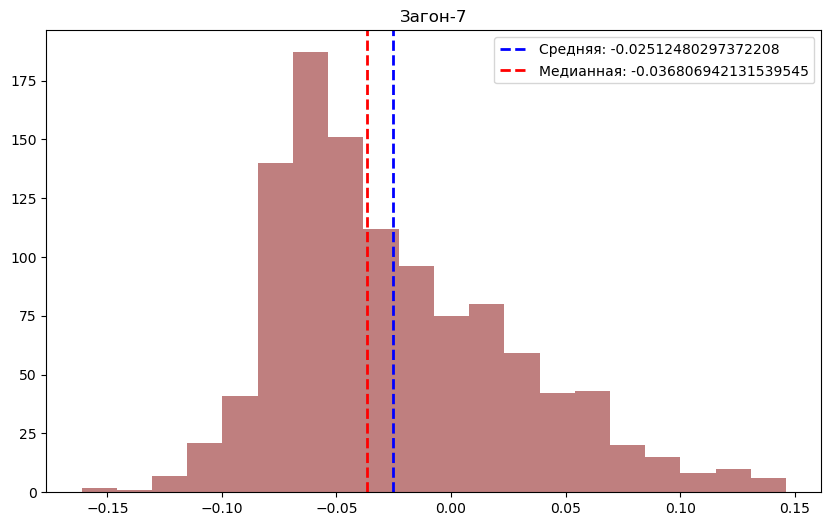

In [118]:
for i, zagon in enumerate(ndii_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(ndii_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(ndii_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = ndii_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(ndii_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(ndii_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {ndii_masked_array[i].mean()}",f"Медианная: {ma.median(ndii_masked_array[i])}",f"Гармоническая: {hmean(ndii_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(ndii_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(ndii_masked_array[i])}",f"Медианная: {ma.median(ndii_masked_array[i])}"])
plt.show()

# Chlorophyll Vegetation Index (CVI)

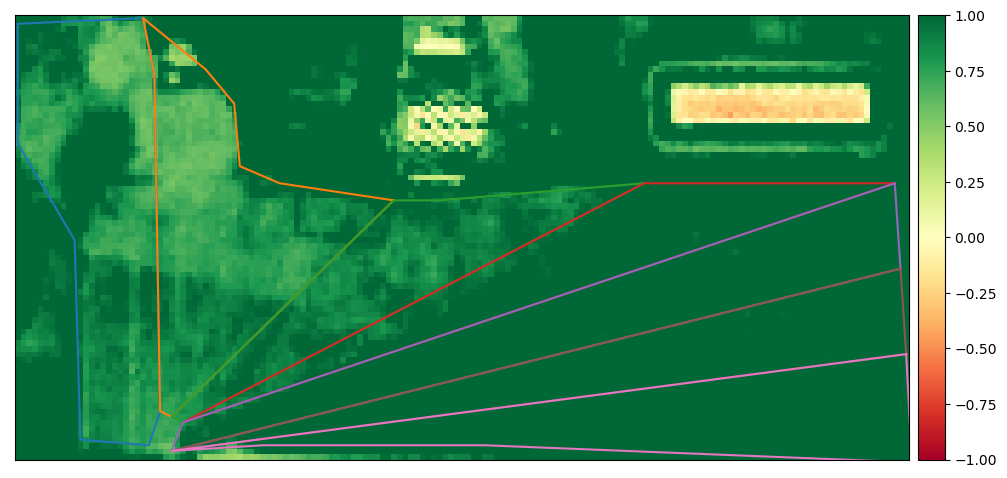

In [120]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

cvi = (NIR / RED) - 1

ep.plot_bands(cvi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [121]:
cvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(cvi, mask=mask.reshape(aoi_height, aoi_width))
    cvi_masked_array.append(mx)

# Статистический анализ данных

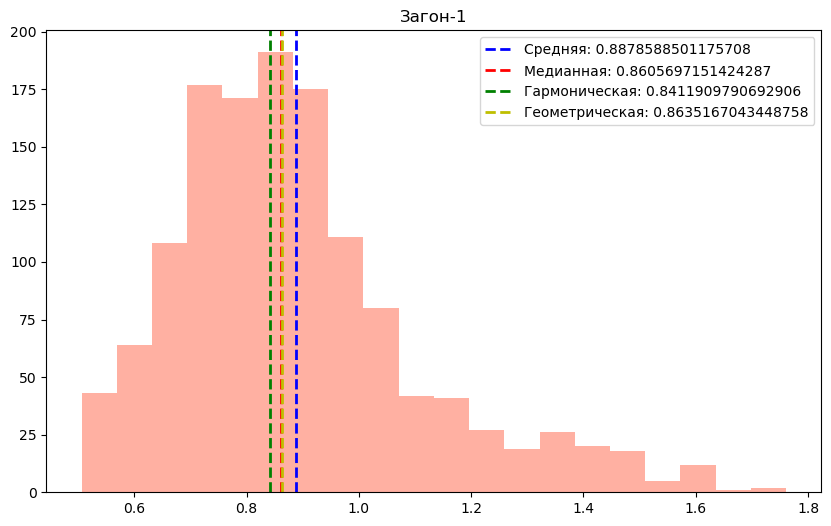

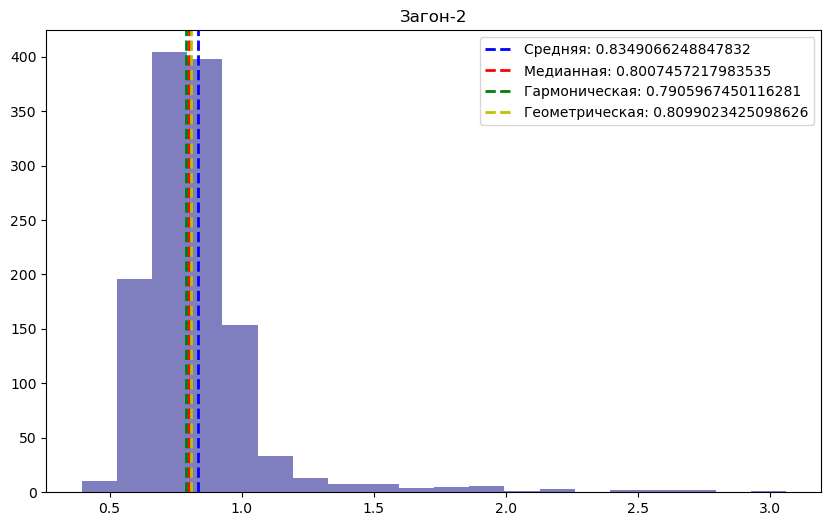

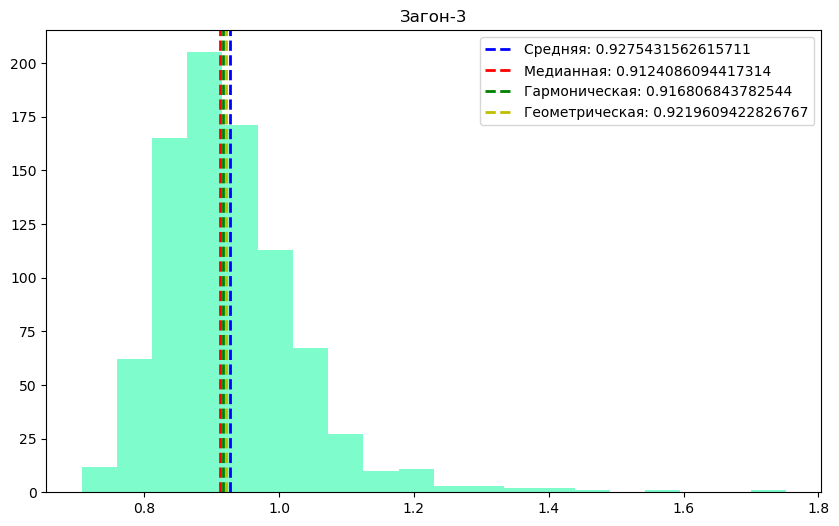

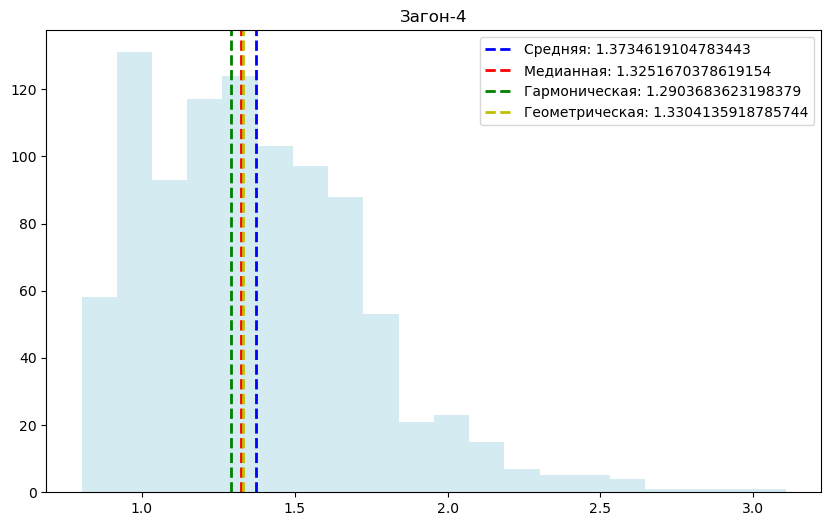

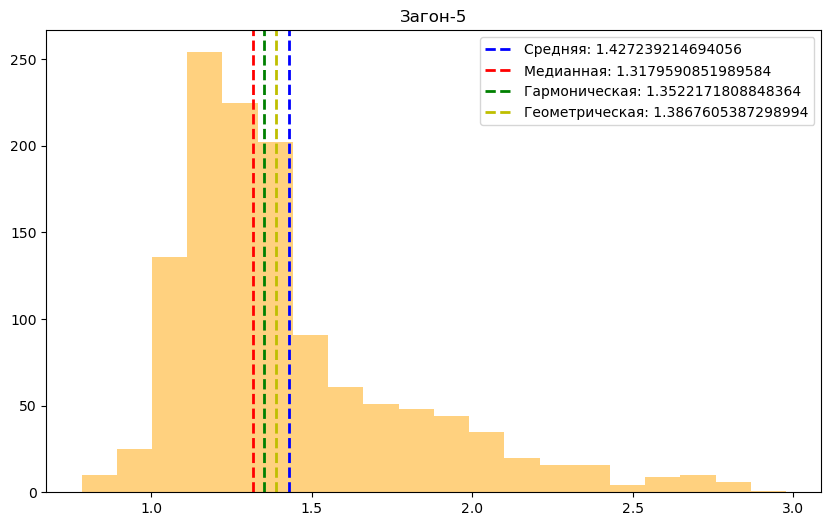

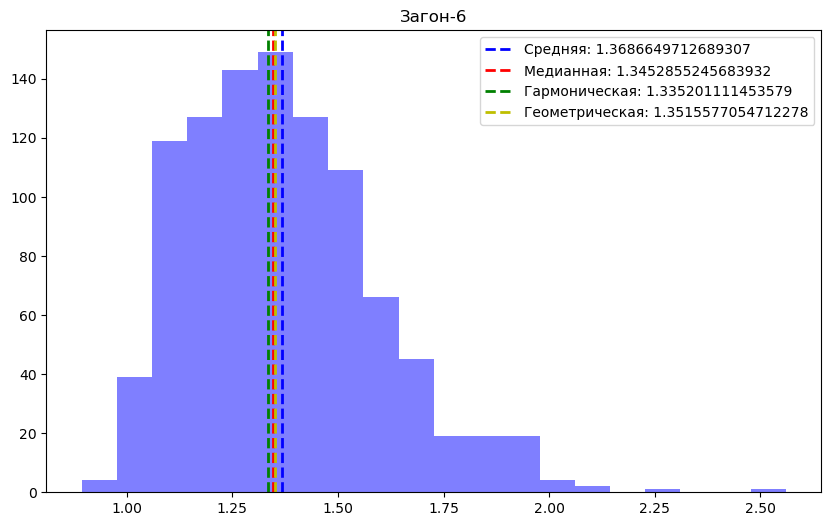

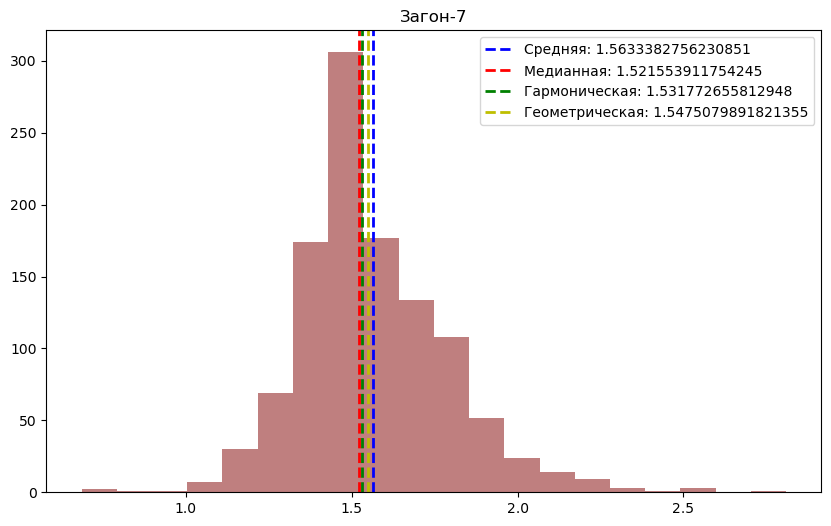

In [122]:
for i, zagon in enumerate(cvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(cvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(cvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = cvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(cvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(cvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {cvi_masked_array[i].mean()}",f"Медианная: {ma.median(cvi_masked_array[i])}",f"Гармоническая: {hmean(cvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(cvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(cvi_masked_array[i])}",f"Медианная: {ma.median(cvi_masked_array[i])}"])
plt.show()

# Photochemical Reflectance Index (PRI)

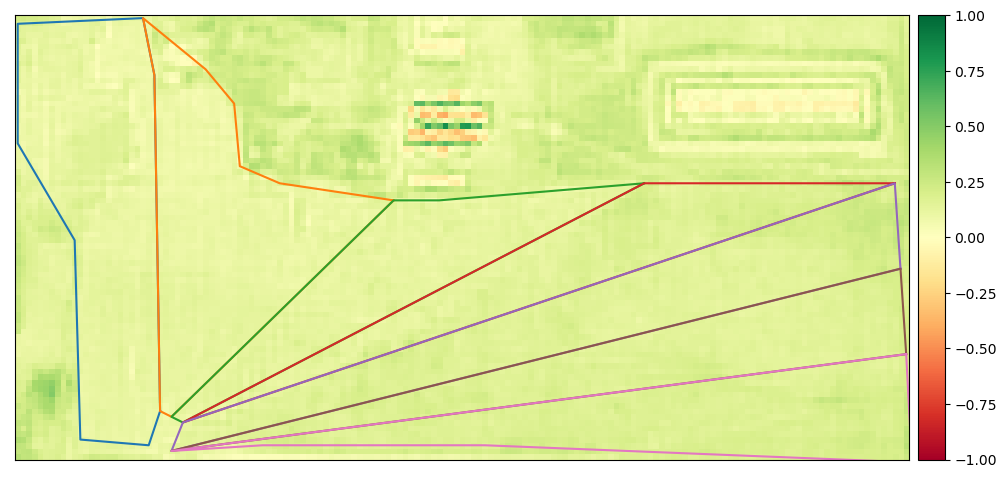

In [131]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

pri = (RED_EDGE1 - RED) / (RED_EDGE1 + RED)

ep.plot_bands(pri, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [132]:
pri_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(pri, mask=mask.reshape(aoi_height, aoi_width))
    pri_masked_array.append(mx)

# Статистический анализ данных

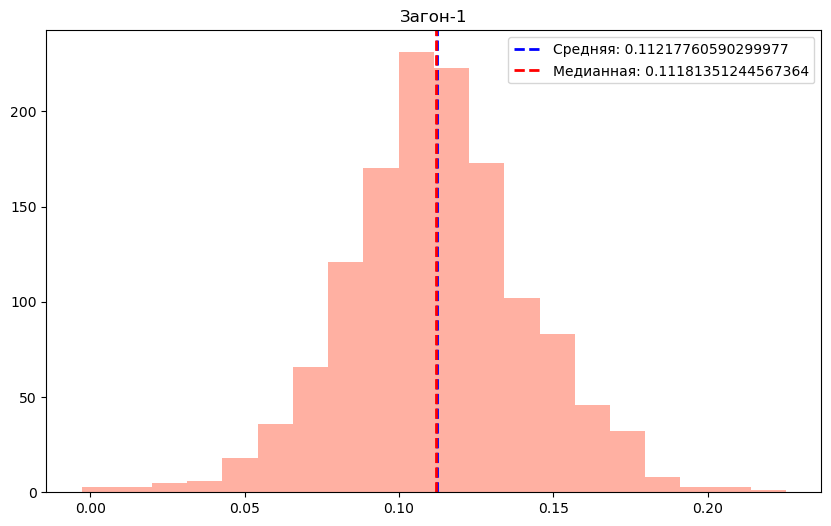

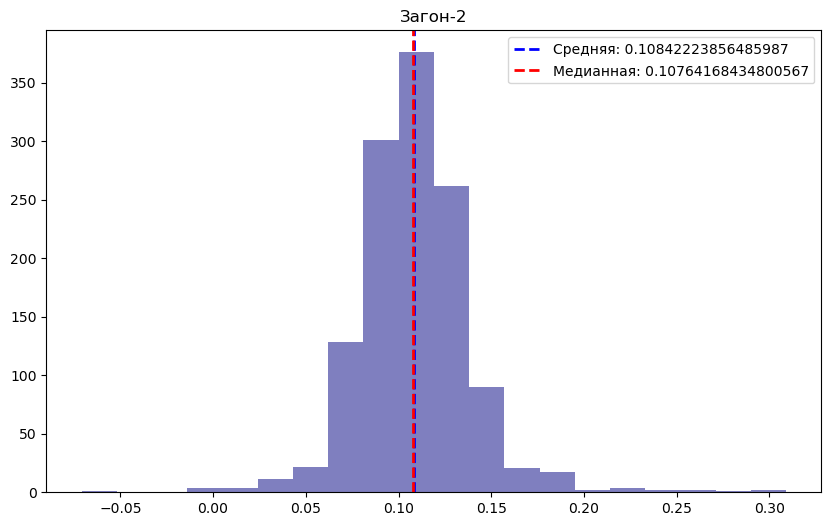

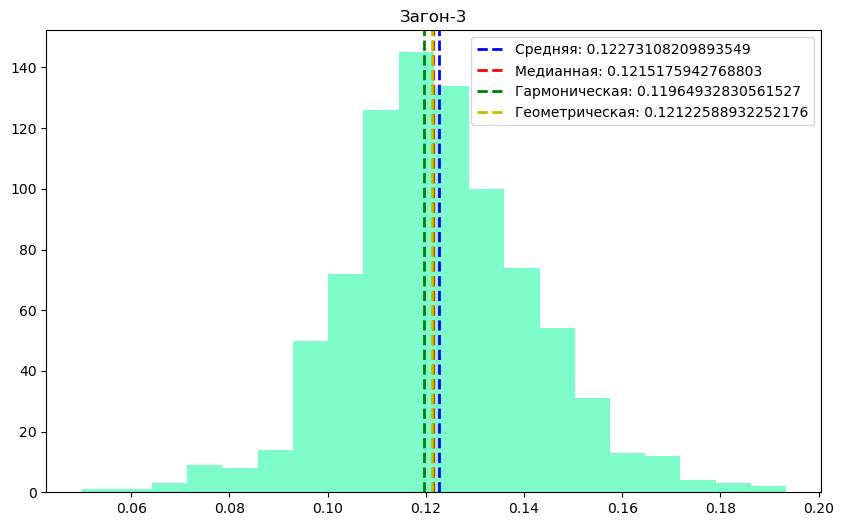

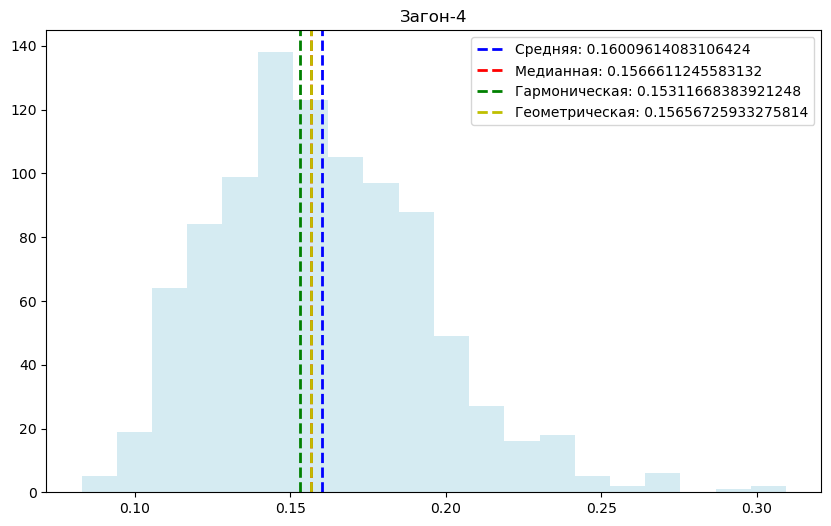

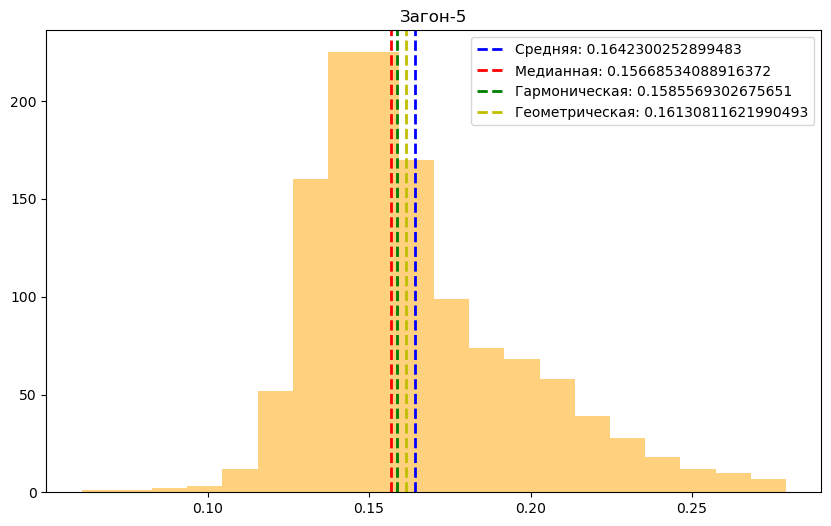

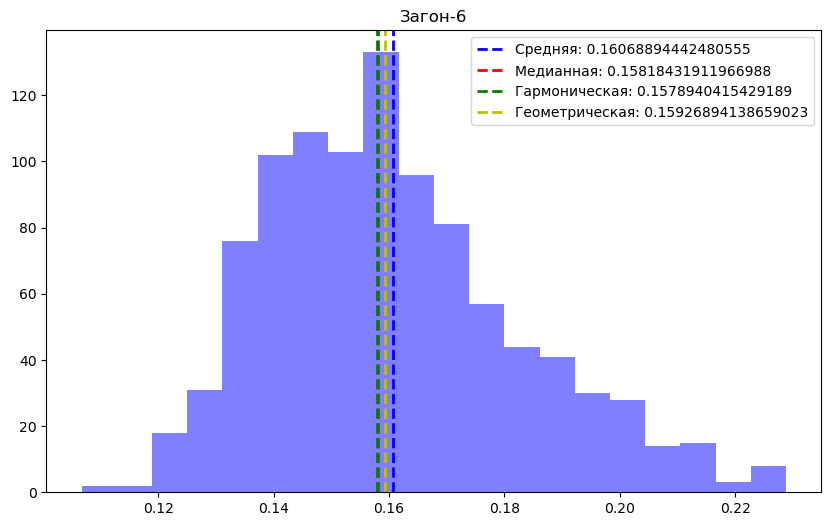

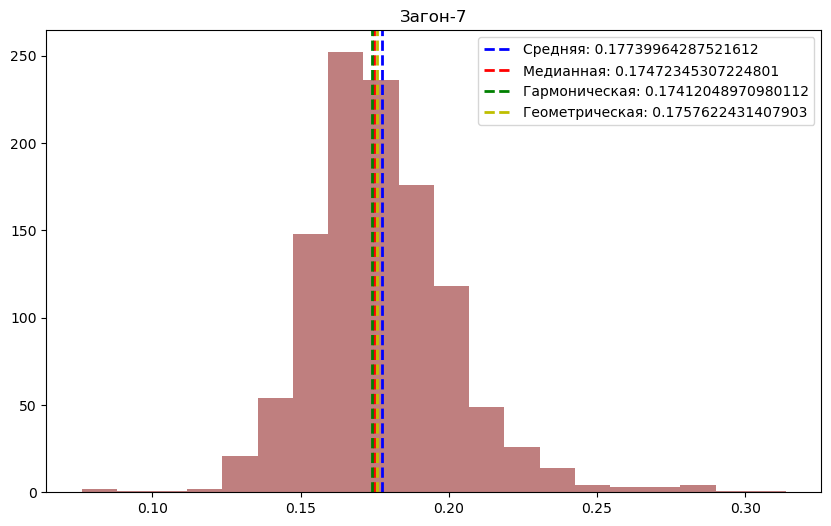

In [133]:
for i, zagon in enumerate(pri_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(pri_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(pri_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = pri_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(pri_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(pri_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {pri_masked_array[i].mean()}",f"Медианная: {ma.median(pri_masked_array[i])}",f"Гармоническая: {hmean(pri_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(pri_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(pri_masked_array[i])}",f"Медианная: {ma.median(pri_masked_array[i])}"])
plt.show()

# Normalized Difference Red Edge Vegetation Index (NDRE)

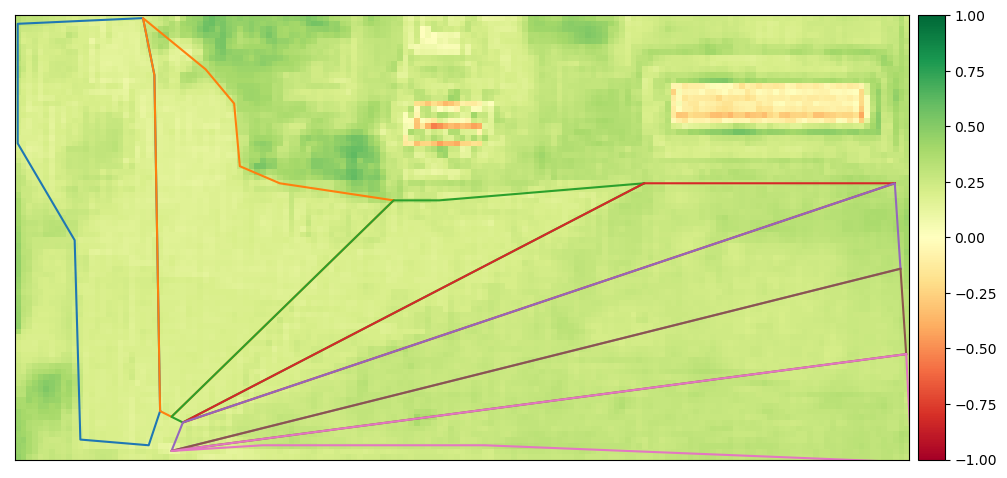

In [134]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ndre = (NIR - RED_EDGE1) / (NIR + RED_EDGE1)

ep.plot_bands(ndre, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [135]:
ndre_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndre, mask=mask.reshape(aoi_height, aoi_width))
    ndre_masked_array.append(mx)

# Статистический анализ данных

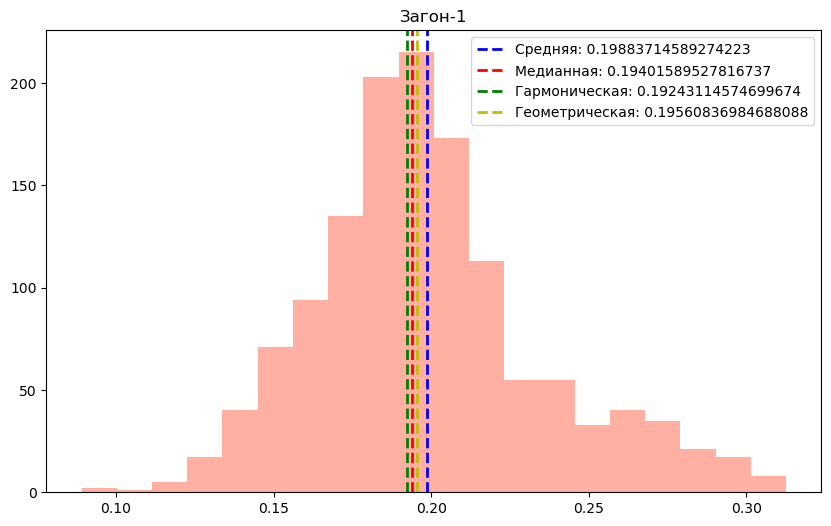

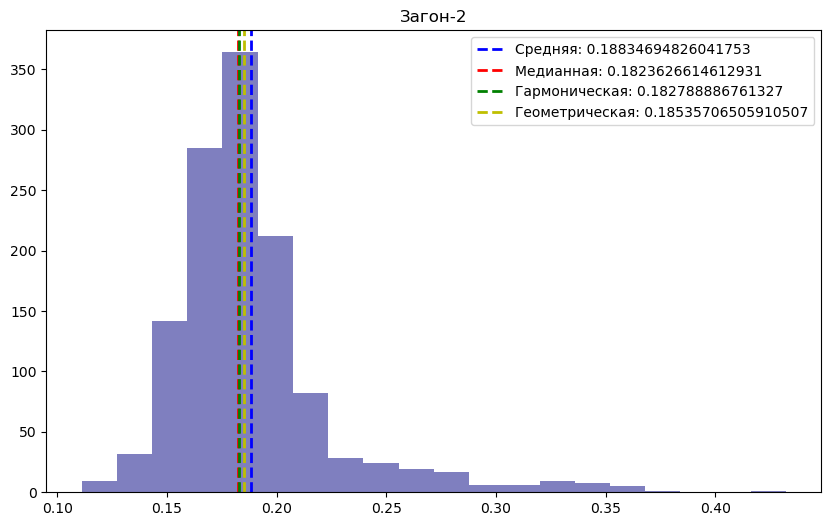

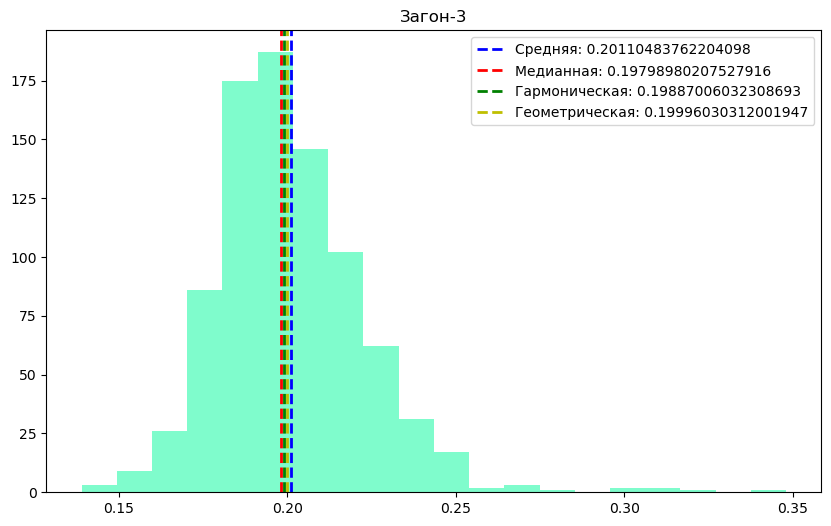

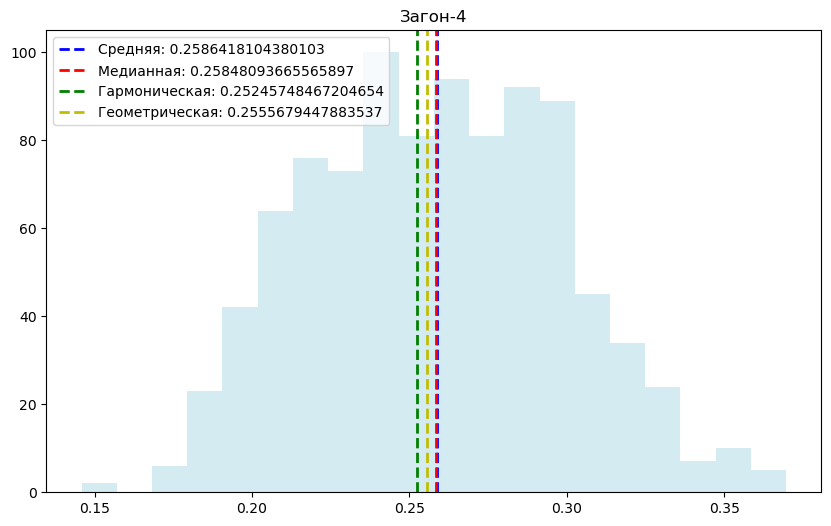

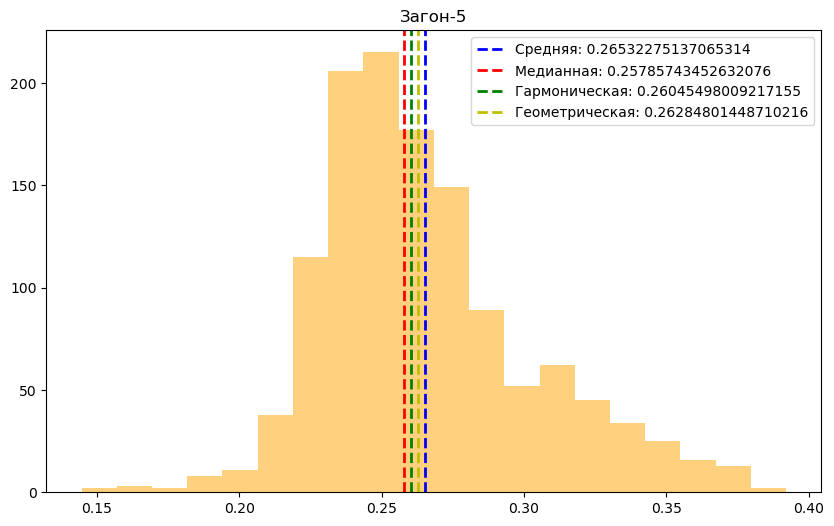

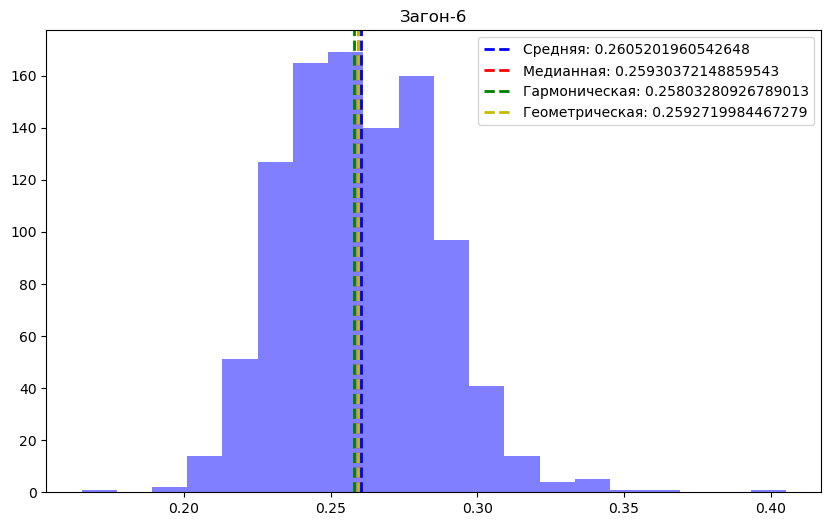

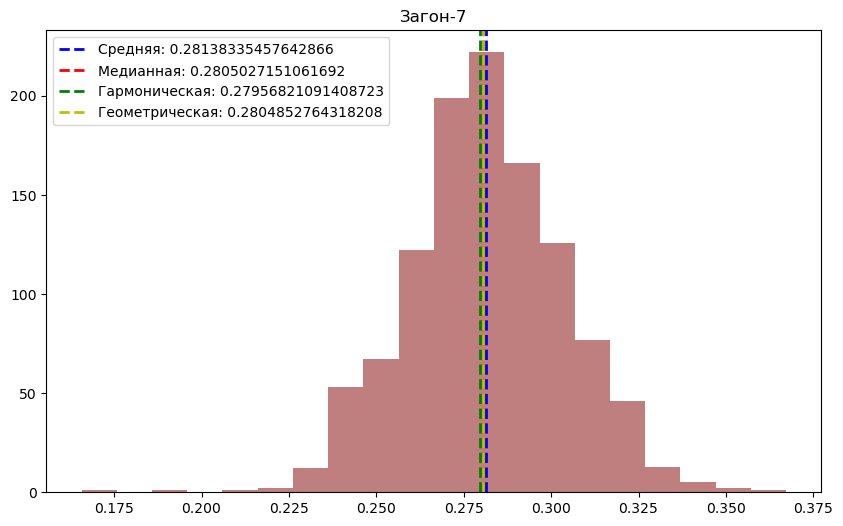

In [136]:
for i, zagon in enumerate(ndre_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(ndre_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(ndre_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = ndre_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(ndre_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(ndre_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {ndre_masked_array[i].mean()}",f"Медианная: {ma.median(ndre_masked_array[i])}",f"Гармоническая: {hmean(ndre_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(ndre_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(ndre_masked_array[i])}",f"Медианная: {ma.median(ndre_masked_array[i])}"])
plt.show()

# Optimized Soil Adjusted Vegetation Index (OSAVI)

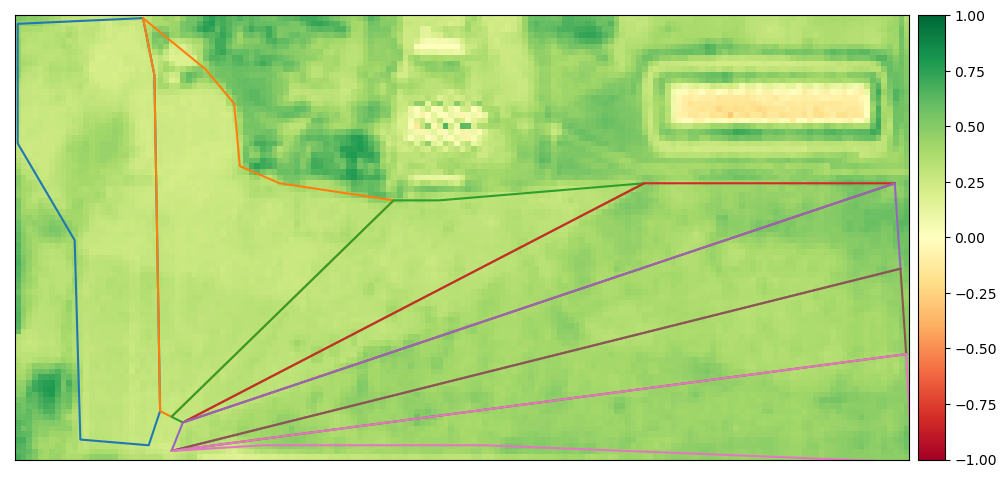

In [138]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

osavi = (NIR - RED) / (NIR + RED + 0.16)

ep.plot_bands(osavi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [139]:
osavi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(osavi, mask=mask.reshape(aoi_height, aoi_width))
    osavi_masked_array.append(mx)

# Статистический анализ данных

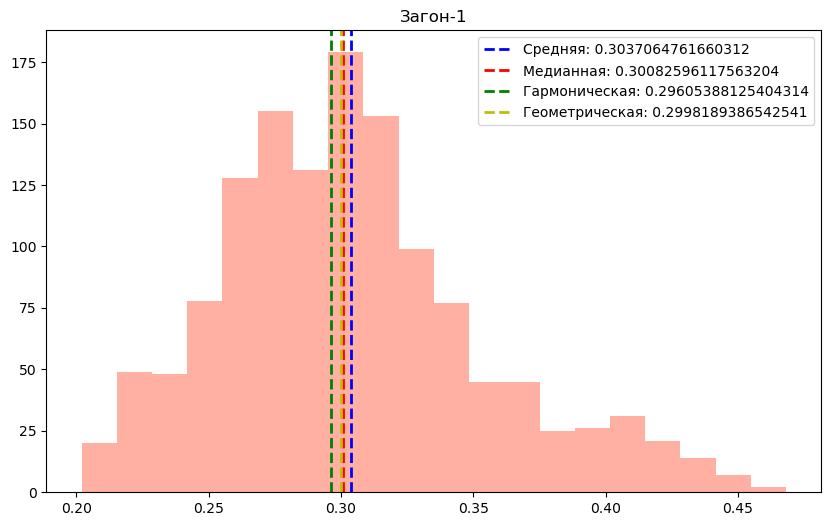

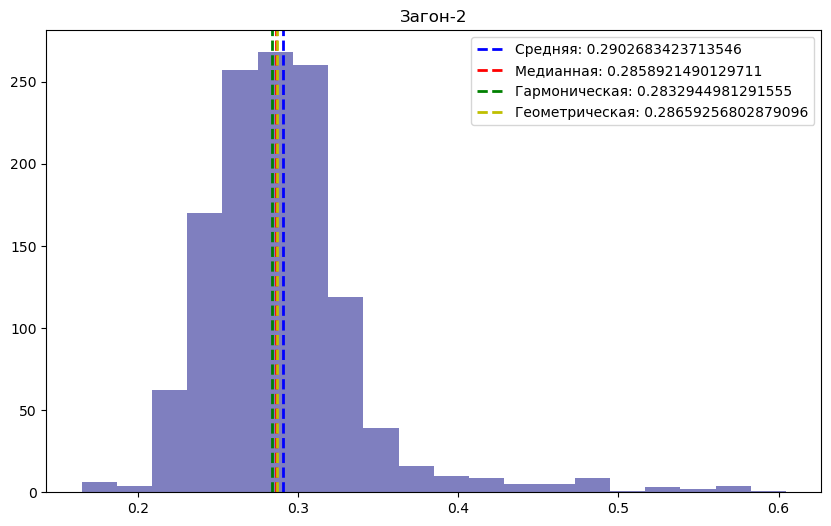

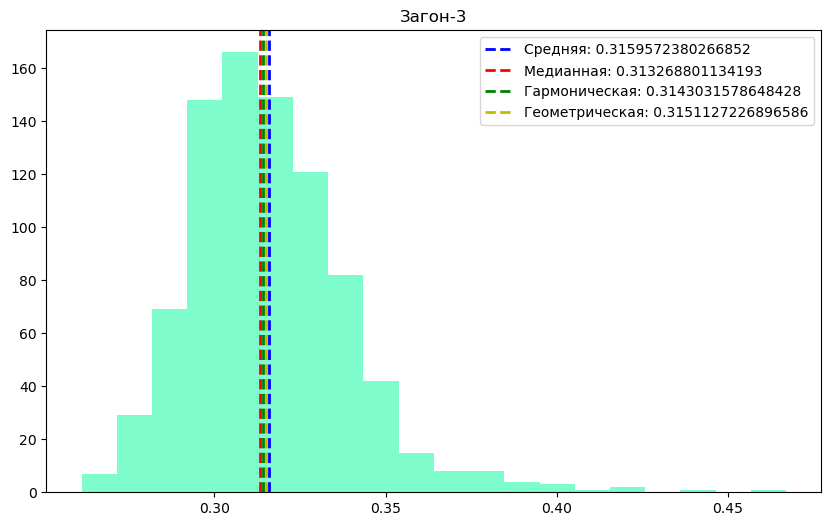

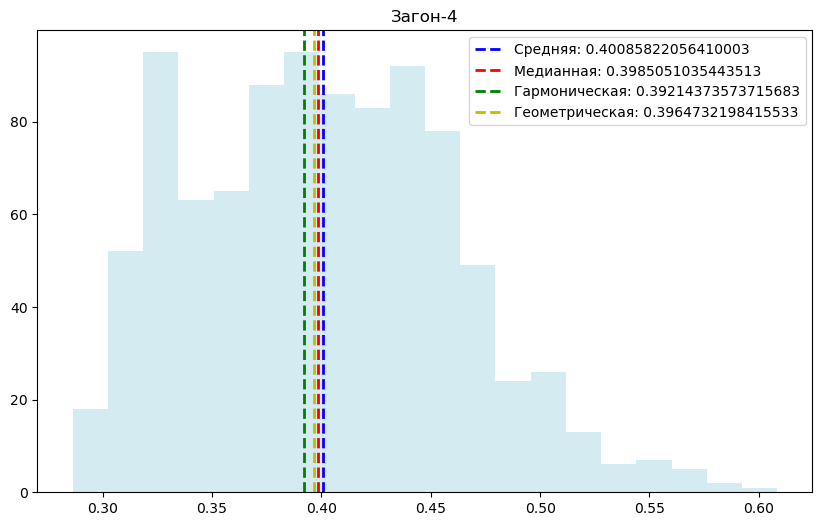

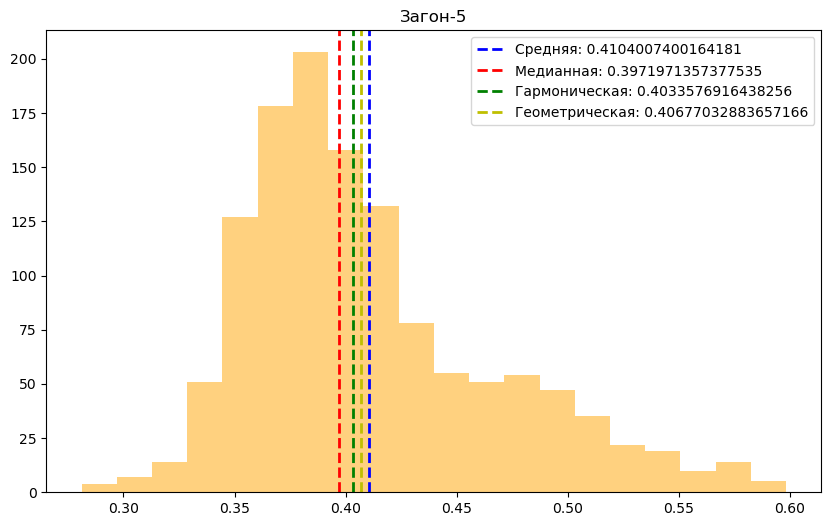

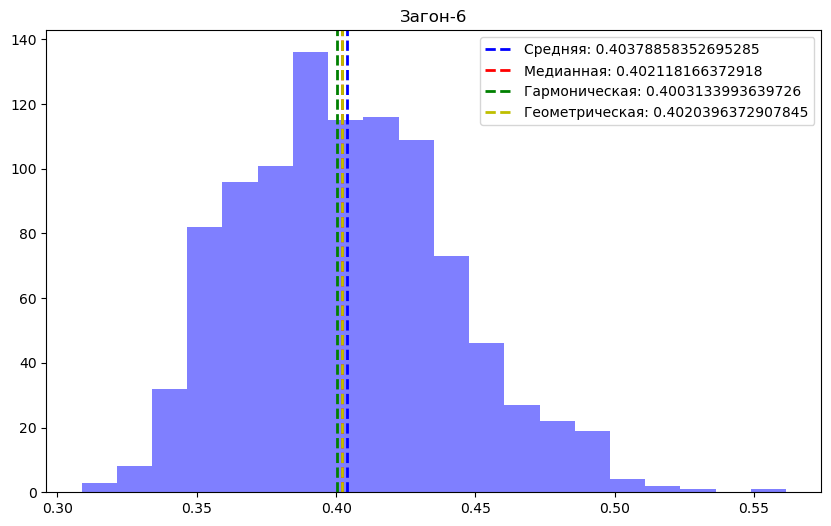

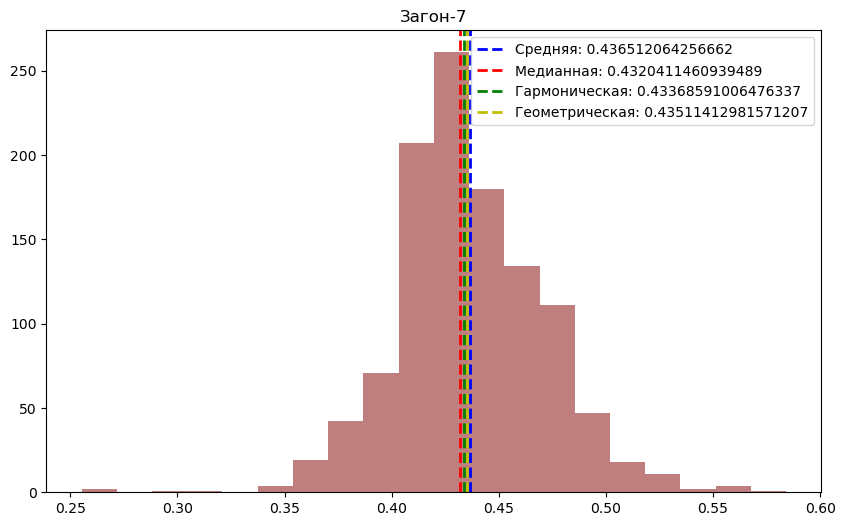

In [140]:
for i, zagon in enumerate(osavi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(osavi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(osavi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = osavi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(osavi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(osavi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {osavi_masked_array[i].mean()}",f"Медианная: {ma.median(osavi_masked_array[i])}",f"Гармоническая: {hmean(osavi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(osavi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(osavi_masked_array[i])}",f"Медианная: {ma.median(osavi_masked_array[i])}"])
plt.show()

# Atmospherically Resistant Vegetation Index (ARVI)

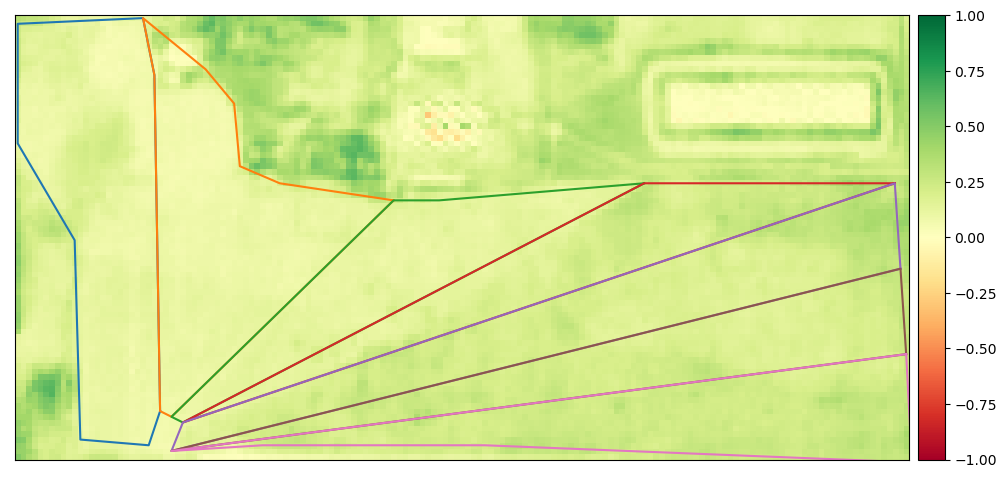

In [141]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

arvi = (NIR - (2 * RED) + BLUE) / (NIR + (2 * RED) + BLUE)

ep.plot_bands(arvi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [142]:
arvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(arvi, mask=mask.reshape(aoi_height, aoi_width))
    arvi_masked_array.append(mx)

# Статистический анализ данных

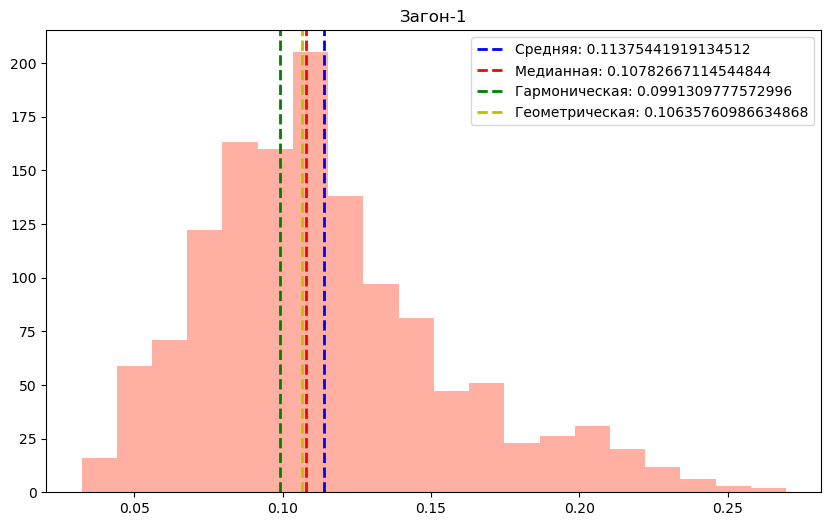

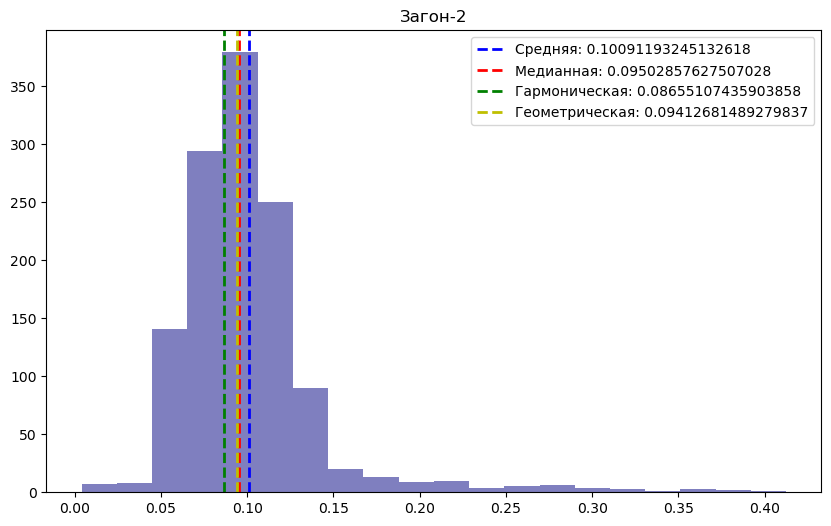

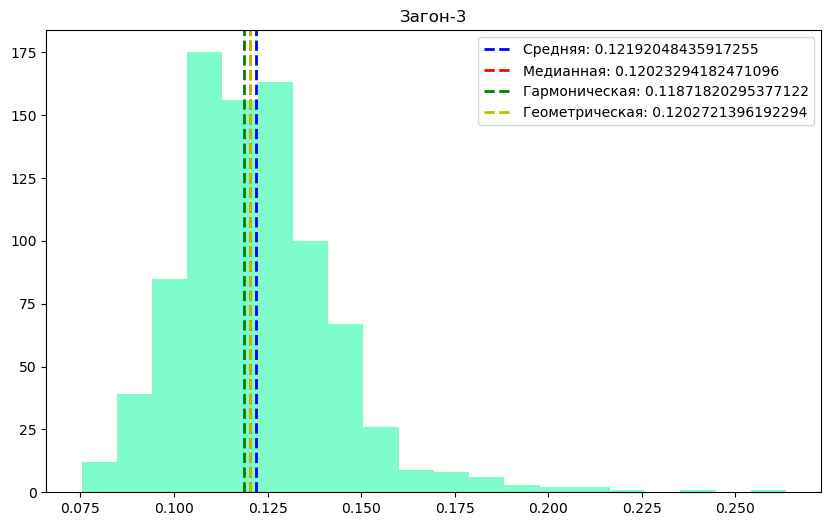

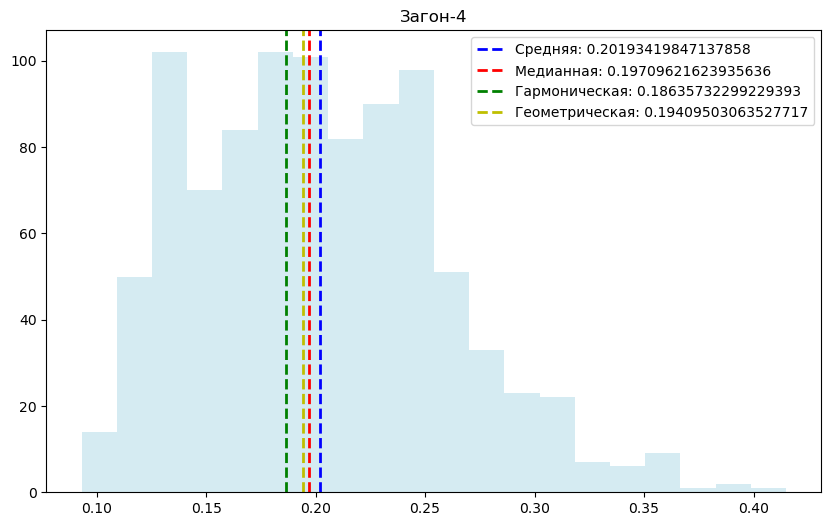

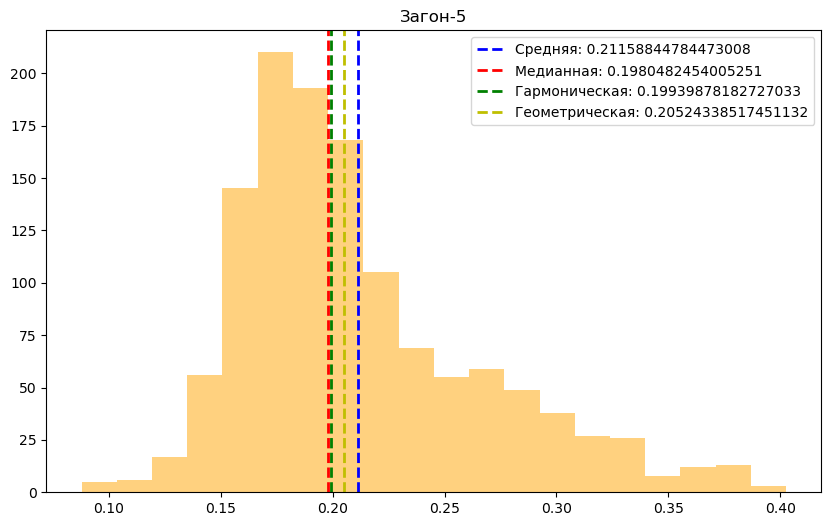

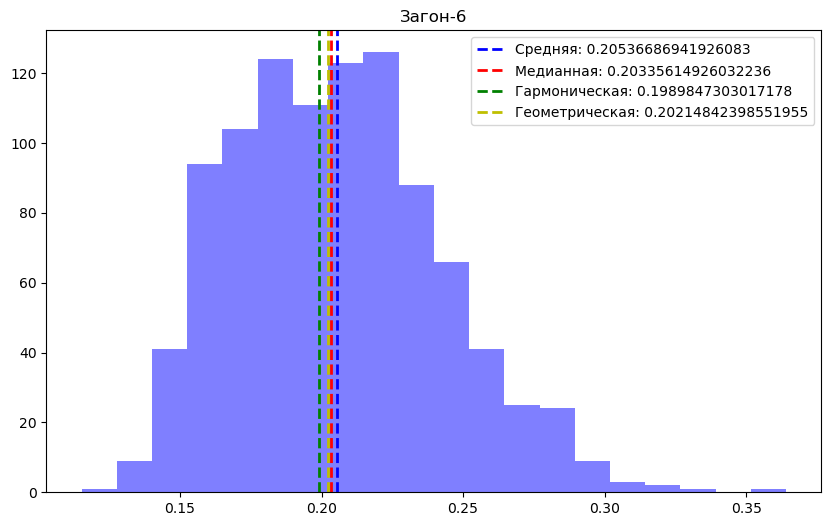

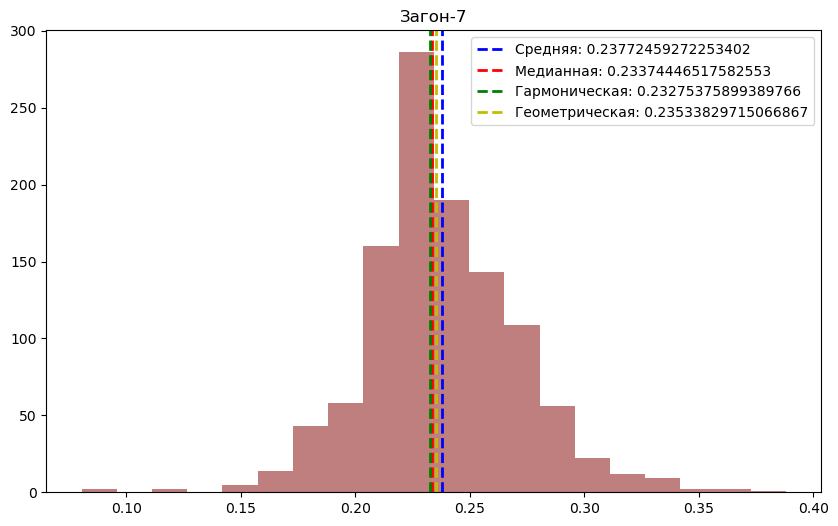

In [143]:
for i, zagon in enumerate(arvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(arvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(arvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = arvi_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(arvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(arvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {arvi_masked_array[i].mean()}",f"Медианная: {ma.median(arvi_masked_array[i])}",f"Гармоническая: {hmean(arvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(arvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(arvi_masked_array[i])}",f"Медианная: {ma.median(arvi_masked_array[i])}"])
plt.show()

# Visible Atmospherically Resistant Index (VARI)

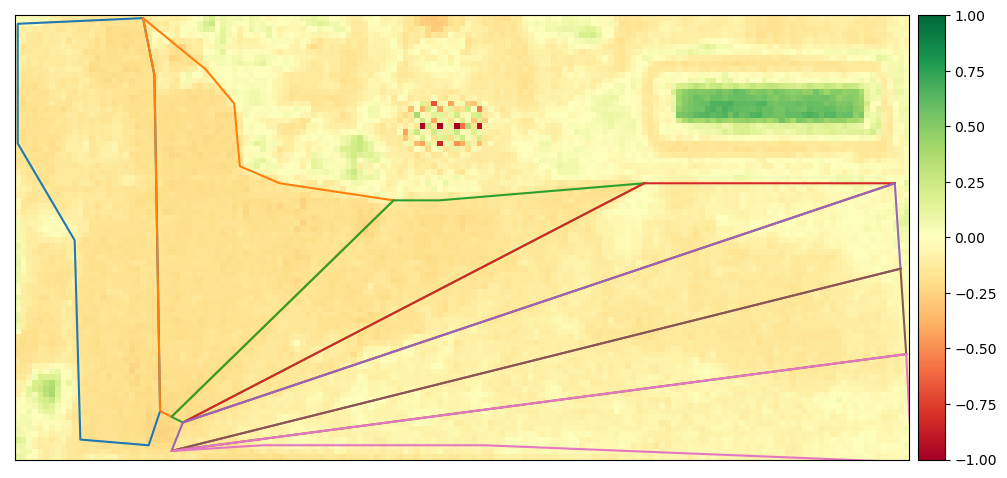

In [144]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

vari = (GREEN - RED) / (GREEN + RED - BLUE)

ep.plot_bands(vari, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [145]:
vari_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(vari, mask=mask.reshape(aoi_height, aoi_width))
    vari_masked_array.append(mx)

# Статистический анализ данных

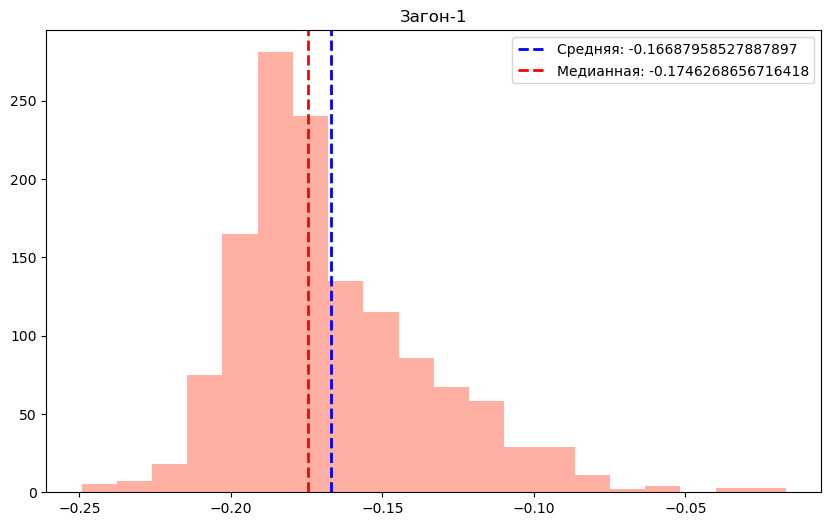

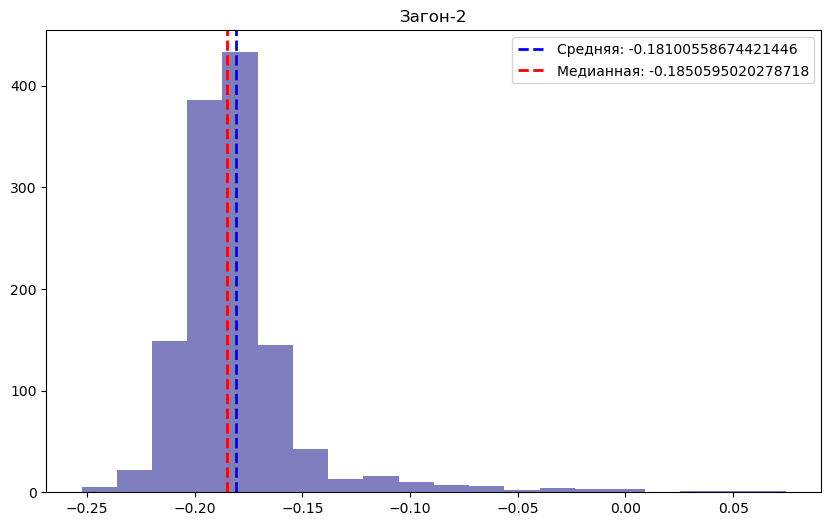

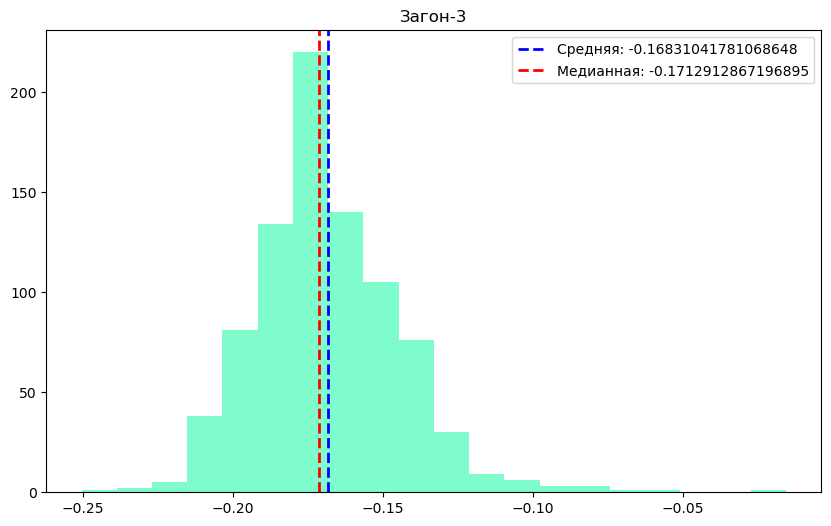

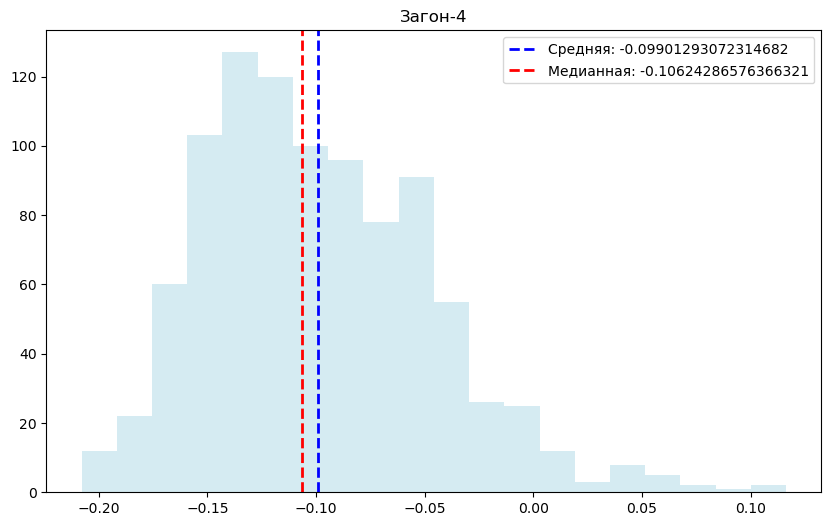

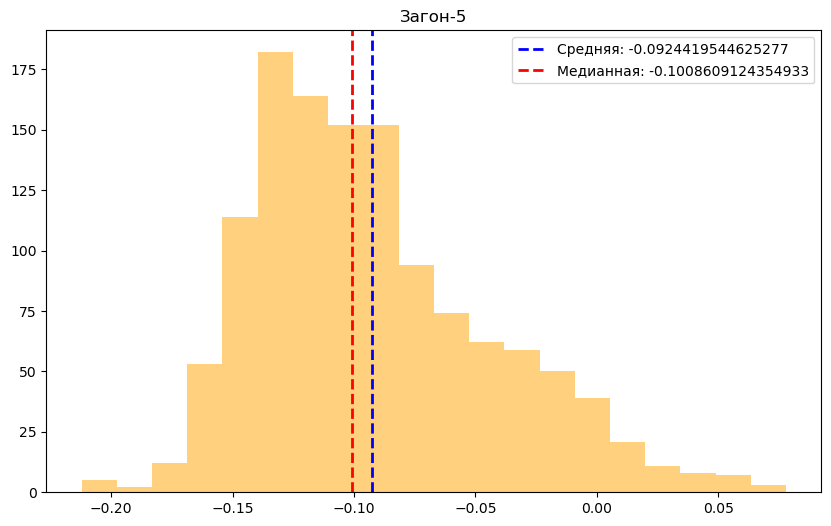

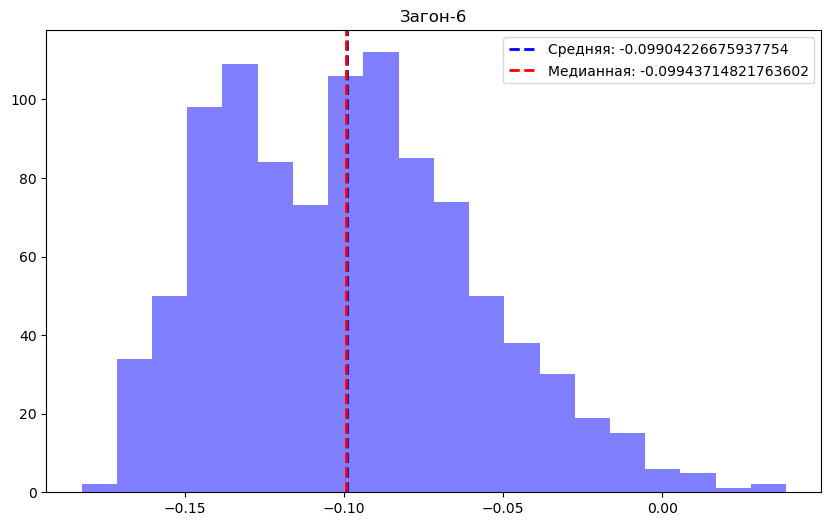

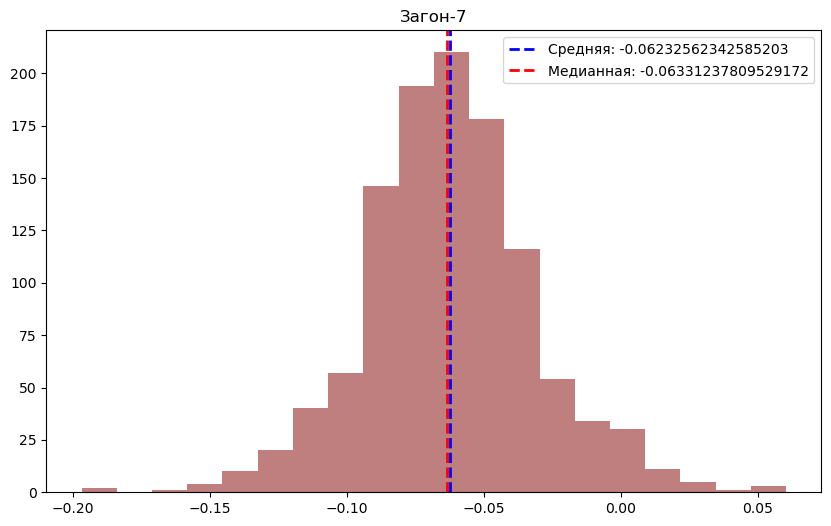

In [146]:
for i, zagon in enumerate(vari_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(vari_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(vari_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    has_negative_or_zero = vari_masked_array[i] <= 0
    if not has_negative_or_zero.sum():
        plt.axvline(hmean(vari_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
        plt.axvline(gmean(vari_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
        plt.legend([f"Средняя: {vari_masked_array[i].mean()}",f"Медианная: {ma.median(vari_masked_array[i])}",f"Гармоническая: {hmean(vari_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(vari_masked_array[i].reshape(aoi_width * aoi_height))}"])
    else:
        plt.legend([f"Средняя: {ma.mean(vari_masked_array[i])}",f"Медианная: {ma.median(vari_masked_array[i])}"])
plt.show()

# Анализ маршрутных точек

In [41]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

In [42]:
all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)

In [43]:
merged_zagons = unary_union(all_zagons)

In [44]:
x_min, y_min, x_max, y_max = merged_zagons.bounds

In [45]:
print("x_min   ||   y_min   ||   x_max   ||   y_max")
print(x_min, y_min, x_max, y_max)

x_min   ||   y_min   ||   x_max   ||   y_max
69.508097 54.211517 69.532304 54.21838700000001


In [46]:
width, height = aoi_width, aoi_height
step_by_x = (x_max - x_min)/width
step_by_y = (y_max - y_min)/height

print(step_by_x, step_by_y)

0.0001541847133757317 8.807692307700475e-05


In [47]:
fname = './route_coords.gpx'
gdf = gpd.read_file(fname)

In [48]:
probes = []
for i, index in enumerate(gdf[["name", "geometry"]].iterrows(), 1):
    index, (name, point) = index
    for x, y in point.coords:
        probes.append((name, (y, x)))

probes_dict = dict(probes)

# Запись значении составленных Индексов

In [157]:
with open('vegetation_indices_comparision.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Точка", "Широта", "Долгота", "у", "х", "NDVI", "SAVI", "REVI", "EVI", "TVI", "GNDVI", "NDII", "CVI", "PRI", "NDRE", "OSAVI", "ARVI", "VARI"])
    for name, (curr_coord_y, curr_coord_x) in probes_dict.items():
        x = int(np.interp(curr_coord_x, [x_min, x_max], [0, width])) # 157
        y = int(np.interp(curr_coord_y, [y_min, y_max], [height, 0])) # 78
#         print(f"Точка: {name} || Координаты: {curr_coord_y}, {curr_coord_x} || Пиксельный эквивалент: {y}, {x} || Значение REVI: {revi[int(y), int(x)]}")
        writer.writerow([name, curr_coord_y, curr_coord_x, y, x, ndvi[int(y), int(x)], savi[int(y), int(x)], revi[int(y), int(x)], evi[int(y), int(x)], tvi[int(y), int(x)], gndvi[int(y), int(x)], ndii[int(y), int(x)], cvi[int(y), int(x)], pri[int(y), int(x)], ndre[int(y), int(x)], osavi[int(y), int(x)], arvi[int(y), int(x)], vari[int(y), int(x)]])

# Чтение для последующего анализа

In [245]:
indices_df = pd.read_csv("data_correlation_check.csv").dropna(1)
indices_df

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_9876\2762163282.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  indices_df = pd.read_csv("data_correlation_check.csv").dropna(1)


Точка     Широта    Долгота   у   х      NDVI      SAVI      REVI  \
0   ПвЗАГ2ОБР1  54.213129  69.514310  59  40  0.324340  0.486441  0.511225   
1   ПвЗАГ2ОБР2  54.213864  69.515271  51  46  0.316539  0.474743  0.480296   
2  ПвЗАГ2ОБР10  54.214590  69.516632  43  55  0.300122  0.450114  0.399608   
3      Пв3обр6  54.213925  69.519030  50  70  0.337621  0.506349  0.551081   
4      Пв3обр5  54.213274  69.517736  58  62  0.431365  0.646931  0.821198   
5      Пв3обр3  54.212929  69.516105  61  51  0.324425  0.486547  0.499160   
6      Пв3обр2  54.212657  69.515235  65  46  0.309890  0.464750  0.505051   
7      Пв3обр1  54.212449  69.514425  67  41  0.315446  0.473083  0.413874   

        EVI       TVI      NDII       CVI       PRI      NDRE     OSAVI  \
0  0.715171  0.569508  0.005978  0.960067  0.129301  0.203576  0.324325   
1  0.712173  0.562618  0.002711  0.926282  0.130919  0.193644  0.316525   
2  0.676157  0.547833 -0.108333  0.857639  0.140619  0.166530  0.300107   
3  0.811187  0.581051 -0.093682  1.019417  0.131168  0.216019  0.337603   
4  1.068353  0.656784 -0.100796  1.517197  0.160428  0.291081  0.431340   
5  0.800366  0.569583 -0.152293  0.960440  0.133333  0.199731  0.324405   
6  0.741845  0.556678 -0.145520  0.898089  0.115493  0.201613  0.309872   
7  0.789760  0.561646 -0.141302  0.921610  0.152223  0.171456  0.315428   

       ARVI      VARI  Урожайность  
0  0.125500 -0.178218          0.4  
1  0.120817 -0.162382          0.7  
2  0.107668 -0.175074          0.7  
3  0.143451 -0.125506          0.9  
4  0.227742 -0.063830          0.9  
5  0.134570 -0.136194          1.0  
6  0.120448 -0.169118          0.8  
7  0.128347 -0.127240          1.1

In [246]:
indices_df = indices_df.iloc[:,5:]

In [247]:
indices_corr_df = indices_df.corr()

<AxesSubplot:>

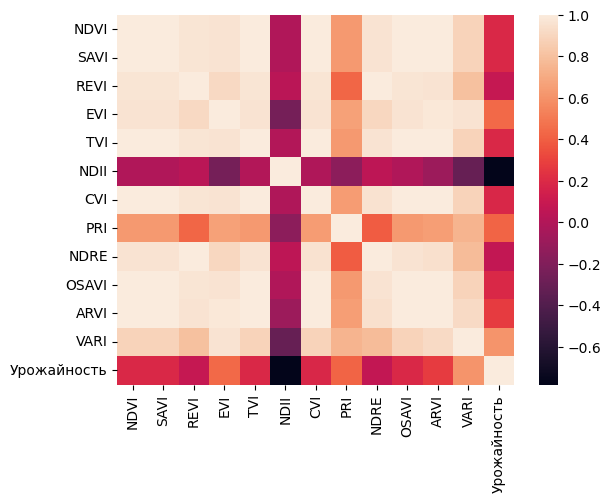

In [248]:
sns.heatmap(indices_corr_df, 
        xticklabels=indices_corr_df.columns,
        yticklabels=indices_corr_df.columns)

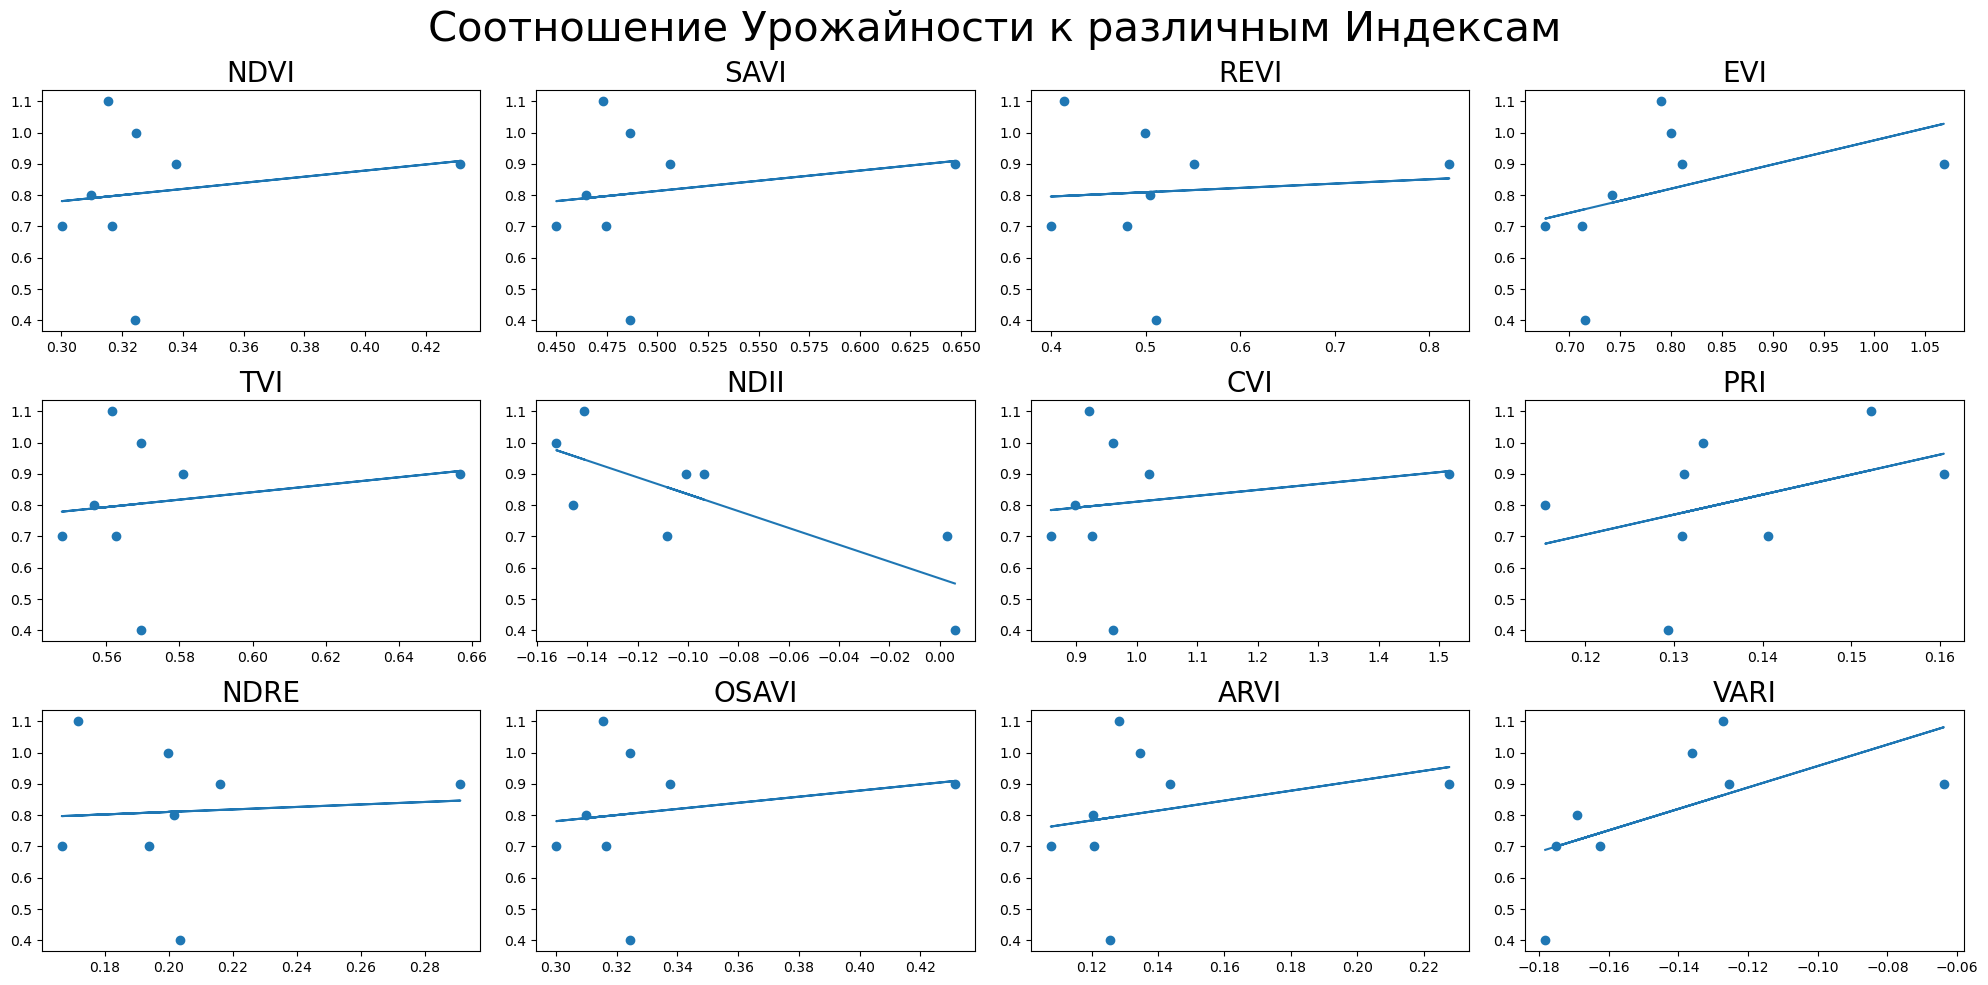

In [256]:
cols = 4
ncols, nrows = cols, ceil(len(list(indices_df.columns[:-1]))/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(20, 10)
)
idx = 0
fig.suptitle("Соотношение Урожайности к различным Индексам", size=30)
for col_name in list(indices_df.columns[:-1]):
    ax = axis[idx // ncols][idx % ncols]
    z = np.polyfit(indices_df[col_name], indices_df["Урожайность"], 1)
    p = np.poly1d(z)
    ax.scatter(indices_df[col_name], indices_df["Урожайность"])
    ax.plot(indices_df[col_name], p(indices_df[col_name]))
    ax.set_title(col_name, fontsize=20)
    idx += 1
        
plt.tight_layout()